In [2]:
import numpy as np
import tangos as db
import pickle as pck
import pynbody
import matplotlib.pyplot as plt
import scipy.integrate as integ
import math as ma
plt.ion()

plt.rcParams['figure.figsize'] = (12, 9) 
plt.rcParams['font.size'] = 20  
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['xtick.major.size'] = 10 
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

sim = db.get_simulation('h1.cosmo50')

In [3]:
def host_density(halo_num,bh_index,R_min=0.7,R_max=1.75,plot:bool=False):
    
    halo= db.get_halo('h1.cosmo50/%4096/'+str(halo_num))
    bh = halo['BH_central'][bh_index]
    mass = bh['BH_mass']
    bhid = bh.halo_number
    dist = bh['BH_central_distance']
        
    #shrink_h1,time_h1,max_radius = halo.calculate_for_progenitors('shrink_center','t()','max_radius')
    hostid,host_path,time,center_dist = bh.calculate_for_progenitors('host_halo.halo_number()','host_halo.path()','t()','BH_central_distance')
    
    if all(i>1 for i in center_dist):
        print('ERROR: This BH was never central')
        return -1,0,0,0,mass,bhid,0,0,dist,0,0,0
    
    if all(i==halo_num for i in hostid):
        print('ERROR: This BH never left the input halo')
        return 0,-1,0,0,mass,bhid,0,0,dist,0,0,0
    
    index = np.where(hostid!=halo_num)[0][0]

    if center_dist[index]>1:
        
        for i in range(len(hostid)):
            
            if (hostid[i]!=halo_num) & (center_dist[i]<1):
                index = i
                break
            else:
                pass
    
    original_halo = db.get_halo(host_path[index])

    shrink = original_halo['shrink_center']
    #print(shrink)
    dist1 = np.sqrt(((shrink[0])**2)+((shrink[1])**2)+((shrink[2])**2))
    #print(dist)

    z = host_path[index].split('.')[-1][0:6]
    #print(z)
    halo2 = db.get_halo('h1.cosmo50/%'+str(z)+'/1')
    shrink2 = halo2['shrink_center']
    #print(shrink2)
    dist2 = np.sqrt(((shrink2[0])**2)+((shrink2[1])**2)+((shrink2[2])**2))
    #print(dist2)
    radius = halo2['max_radius']
    difference = np.abs(dist2-dist1)
    #print(difference)
    #print(host_path[index])
    if difference < radius:
    
        #print('First original inside h1')
    
        inside=-1
        outside:bool = False
    
        while outside==False:
        
            #print(outside)
            index+=1
            if index >= len(hostid):
                print('ERROR the BH never met the three conditions')
                return 0,0,0,0,mass,bhid,-1,0,dist,0,0,0

            if (hostid[index]!=halo_num) & (center_dist[index]<1):
                
                original_halo = db.get_halo(host_path[index])
            
                #print(original_halo)
            
                shrink = original_halo['shrink_center']
            
                #print(shrink)
            
                dist1 = np.sqrt(((shrink[0])**2)+((shrink[1])**2)+((shrink[2])**2))
            
                #print('original halo:',dist)
            
                z = host_path[index].split('.')[-1][0:6]
                halo2 = db.get_halo('h1.cosmo50/%'+str(z)+'/1')
                shrink2=halo2['shrink_center']
                dist2= np.sqrt(((shrink2[0])**2)+((shrink2[1])**2)+((shrink2[2])**2))
                #print(shrink2)
                #print('halo1:',dist2)
            
                diff = abs(dist2-dist1)
                radius = halo2['max_radius']
                #print('rad:',radius)
                #print('diff:',diff)
            
                if diff>=radius:
                    #print('yes')
                    outside = True
                
                                   
    else:   
        inside = 0

        
    step = time[index]
    full_mass = original_halo['Mstar']
    
    if step < 0.65:
        print('ERROR: no original host')
        return 0,0,0,0,mass,bhid,original_halo,step,dist,0,inside,0
              
    if full_mass>10000000:
        res=0
    else:
        res=-1
        print('ERROR: host galaxy not resolved')
        return 0,0,0,0,mass,bhid,original_halo,step,dist,res,inside,0
    
    if 'star_density_profile' in original_halo:
        print('Original BH Host:',original_halo.halo_number)
        print('BH id:',bhid)
        print('Time in simulation:',step,'Gyr') 
    else:
        print('ERROR: The original host has no density profile')
        return  0,0,-1,0,mass,bhid,original_halo,step,dist,res,inside,0
    
    rbins = np.arange(len(original_halo['star_density_profile']))*0.1+0.5
    density = original_halo['star_density_profile']
    ok = np.where(density>0) 
    start_cut_off = (R_min*10)-5
    end_cut_off=(R_max*10)-4
    rounded = round(R_max,1)
    
    if rounded!=R_max:
        end_cut_off+=1   
        
    if len(density[ok])==0:
        print('ERROR: Star density within '+str(R_min)+'kpc is zero')
        return 0,0,full_mass,-1,mass,bhid,original_halo,step,dist,res,inside,0
    
    if 'star_mass_profile' in original_halo:
        original_mass = original_halo.calculate('at('+str(R_min)+',star_mass_profile)')
        if original_mass ==0:
            original_mass=1
    else:
        original_mass = 1  
    
    check = np.array_equal(density,density[ok])
    zero=0   
    
    if check==False:
        #print('ERROR: Zero density values detected - erased from plot')
        zero=-1
       
    plotbins = rbins[ok][0:int(end_cut_off)]
    plot_density = density[ok][0:int(end_cut_off)]

    steps = rbins[ok][int(start_cut_off):int(end_cut_off)]
    
    if len(steps) == 0:
        print('ERROR: Not enough density points to evaluate')
        return 0,0,full_mass,0,-1,bhid,original_halo,step,dist,res,inside,0
    
    y = np.log(plot_density[int(start_cut_off):int(end_cut_off)])
    x = np.log(steps)

    constants = np.polyfit(x,y,1)
    a = np.exp(constants[1])
    b = -constants[0]
   
    #print('Parameters:',a,b) 

    steps2 = np.arange(0,R_min,0.1)
    new_steps = np.append(steps2,steps)

    plotbins2 = np.arange(0,0.5,0.1)
    new_plotbins = np.append(plotbins2,plotbins)

    def function(x):
        y = []
        y = a*x**(-b)
        return y

    y = function(new_plotbins)

    if plot==True:
        plt.plot(plotbins,plot_density,ls='-',c='deeppink',lw=4)
        plt.yscale('log')
        plt.ylabel(r'Stellar Density [M$_{\odot}$/kpc$^3$]')
        plt.xlabel(r'R [kpc]')
        #plt.title('Star Density of Host at 0-'+str(R_max)+'kpc')
        plt.axvline(x=center_dist[index], label='BH Location',c='darkblue',lw=2,ls='--')
        plt.axvline(x=0.7,label='Resolution Limit',c='deepskyblue',lw=2,ls='--')
        plt.legend(loc='upper right')
        
        plt.plot(new_plotbins,y,c='pink',ls='-.',label='Extrapolated Star Desnity',lw=3)
        plt.yscale('log')
        plt.legend(loc='upper right')
        
    return a,b,full_mass,original_mass,mass,bhid,original_halo,step,dist,res,inside,zero

Original BH Host: 42
BH id: 568944270
Time in simulation: 2.920323569180768 Gyr


/tmp/ipykernel_1048908/3868814453.py:176: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


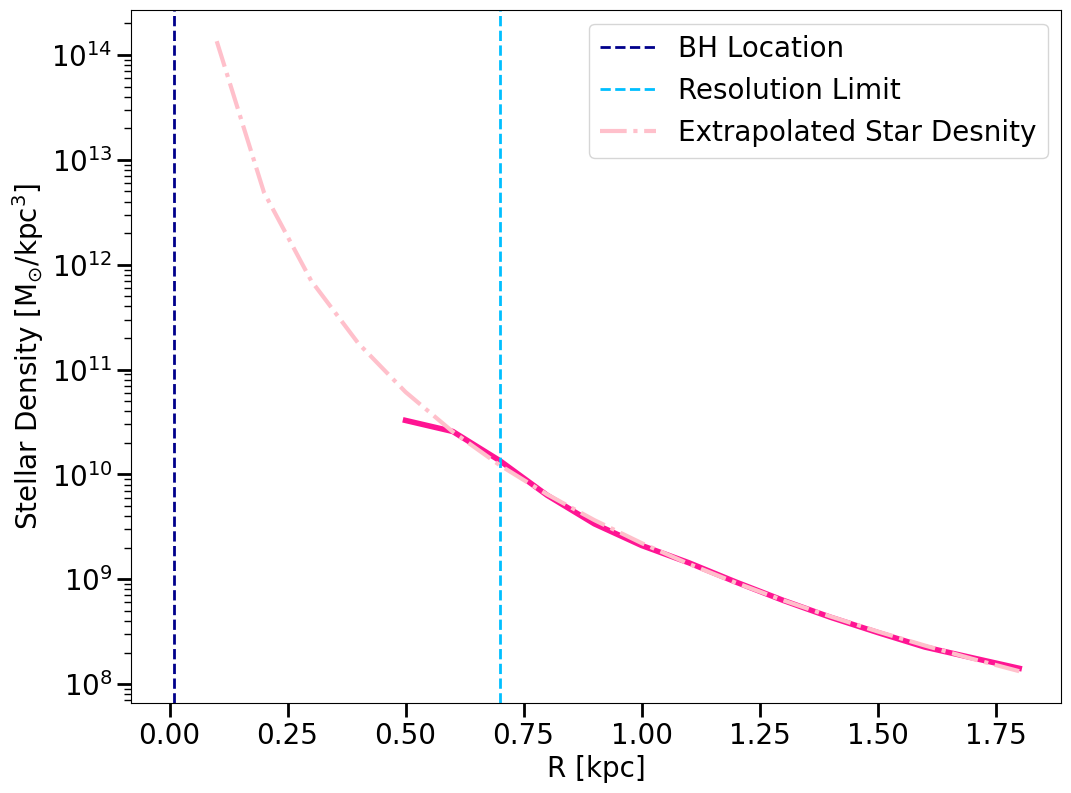

In [5]:
host_density(1,13,plot=True)
plt.savefig('extrapolation.png')

In [3]:
def BHMstar(logMstar):
    '''
    BH mass given a stellar mass
    based on analysis by Haring and Rix 2004 and Schramm + Silverman 2013
    '''
    c = 8.31
    a = 1.12
    b = 11.
    predlogMBH = c + a * (logMstar-b)
    return predlogMBH


def BHMBulge(logMbulge):
    '''
    BH mass given a bulge mass
    based on analysis by Haring and Rix 2004 and Kormendy and Ho 2013
    '''
    c = 8.69
    a = 1.16
    b = 11.
    predlogMBH = c + a * (logMbulge-b)
    return predlogMBH

In [5]:
f = open('Extrapolation_Outputs.pkl','rb')
data = pck.load(f)
f.close()

In [35]:
q,w,e,r,t,y,u,i,m,k,l,n = host_density(1,1)
print(i)
type(i)
x = i.gather_property('t()')
z=str(i)
z.split('=')[-1][0:4]
print(x[0][0])

Original BH Host: 68
Time in simulation: 1.5467983949884065 Gyr
<TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000456' z=3.99 t=1.55 Gyr>


/tmp/ipykernel_347638/685054134.py:169: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


1.5467983949884065


In [38]:
to_file = {'x':i}
f=open('test.pkl','wb')
pck.dump(to_file,f)
f.close()

f=open('test.pkl','rb')
check=pck.load(f)
f.close()

z = check['x']
#z.split('=')[-1][0:4]
x = z.gather_property('t()')
print(x[0][0])

1.5467983949884065


In [5]:
def host_density_values(halo_num,bh_index,R_mass=1):
    
    halo= db.get_halo('h1.cosmo50/%4096/'+str(halo_num))
    bh = halo['BH_central'][bh_index]
    mass = bh['BH_mass']
    dist = bh['BH_central_distance']
    bhid = bh.halo_number
    
    hostid,host_path,time,center_dist = bh.calculate_for_progenitors('host_halo.halo_number()','host_halo.path()','t()','BH_central_distance')
        
    index = np.where(hostid!=halo_num)[0][0]

    if center_dist[index]>1:
        
        for i in range(len(hostid)):
            
            if (hostid[i]!=halo_num) & (center_dist[i]<1):
                index = i
                break
            else:
                pass
    
    original_halo = db.get_halo(host_path[index])
    step = original_halo.timestep
    
    if 'star_mass_profile' in original_halo:
        original_mass = original_halo.calculate('at('+str(R_mass)+',star_mass_profile)')
        if original_mass ==0:
            original_mass=-1
    else:
        original_mass = -1
      
    return step,mass,dist,bhid,original_halo,original_mass,

In [2]:
f = open('Faulty_BHs_ids.pkl','rb')
my_saved_data = pck.load(f)
f.close()
ids=my_saved_data['Error_bhids']

halo = db.get_halo('h1.cosmo50/%4096/1')
all_bhs_h1 = halo['BH_central']
all_ids = []

error_indices = []

for i in range(2193):
    
    all_ids.append(all_bhs_h1[i].halo_number)
    
for i in range(2193):
    if all_ids[i] in ids:
        error_indices.append(i)
        
h1_ids = np.arange(0,2193,1) 

new_ids = np.delete(h1_ids,error_indices)
print(len(new_ids))

533


In [79]:
f = open('Faulty_BHs_ids.pkl','rb')
my_saved_data = pck.load(f)
f.close()
ids=my_saved_data['Error_bhids']

halo = db.get_halo('h1.cosmo50/%4096/1')
all_bhs_h1 = halo['BH_central']
all_ids = []

error_indices = []

for i in range(2193):
    
    all_ids.append(all_bhs_h1[i].halo_number)
    
for i in range(2193):
    if all_ids[i] in ids:
        error_indices.append(i)


In [3]:
f = open('ErrorIDS.pkl','rb')
my_saved_data = pck.load(f)
f.close()
ids=my_saved_data['Error_bhids']

halo = db.get_halo('h1.cosmo50/%4096/1')
all_bhs_h1 = halo['BH_central']
all_ids = []

error_indices = []

for i in range(2193):
    
    all_ids.append(all_bhs_h1[i].halo_number)
    
for i in range(2193):
    if all_ids[i] in ids:
        error_indices.append(i)
        
h1_ids = np.arange(0,2193,1) 

new_ids = np.delete(h1_ids,error_indices)
print(len(new_ids))

KeyError: 'Error_bhids'

In [3]:

def mass_int(a,b,r_min=0,r_max=0.7):
    
    
    if (b>3) & (b!=3) & (b<4):
        #print('ERROR: The integral from 0 is divergent - lower lim = 0.01 instead')
        #r_min = 0.1
       # r_max = 1
        m = ((4*np.pi*a)/(3-b))*((r_max**(3-b))-(r_min**(3-b)))
        #print('The Mass of the host is:',m,str('Msol')) 
    
    if b<3:
   
    #r_min = 0
    #r_max = 1
        m = ((4*np.pi*a)/(3-b))*((r_max**(3-b))-(r_min**(3-b)))
    #print('The Mass of the host is:',m,str('Msol')) 
        
    if b>4:
     #   print('ERROR: b > 4 - lower lim = 0.01 instead')
       # r_min = 0.1
       # r_max = 1
        m = ((4*np.pi*a)/(3-b))*((r_max**(3-b))-(r_min**(3-b)))
        #print('The Mass of the host is:',m,str('Msol')) 
        
    return m



In [68]:
def new_mass_int(a,b,r_min=0.35,r_max=0.7):
    
    m1 = ((4*np.pi*a)/(3-b))*((r_max**(3-b))-(r_min**(3-b)))
    m2 = ((a*(r_min)**(-b))*((4/3)*np.pi*(0.35)**3))
    # print(m1)
    # print(m2)
    m = m1+m2
    
    return m
    

In [69]:
a,b,v,e,r,y,u,i,o,w,q,z = host_density(1,0)
print(a,b)
print(new_mass_int(a,b))
print(mass_int(a,b,r_min=0.35))

Original BH Host: 3
Time in simulation: 0.9812292056226746 Gyr
61869310.11978993 1.2879473355374316
214273483.7934757
171321387.6357925


/tmp/ipykernel_352452/685054134.py:169: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


In [6]:
no_mass_BHid=[]
int_fail_BHid=[]
int_fail_time=[]
int_fail_b=[]

bad_BHid=[]
bad_Gal_mass=[]
bad_BH_mass=[]
bad_host=[]
bad_time=[]
bad_b=[]

Cluster_distance=[]
int_mass = []
b=[]
Gal_mass=[]
sim_mass=[]
BHid=[]
BH_mass=[]
time=[]

for i in new_ids12:
    a,B,gal_mass,original_mass,bh_mass,bhid,halo,step,dist,res,inside = host_density(1,i,R_min=0.7,R_max=1.75)
    
    #if original_mass==0:
     #   error+=1
        #error_bhid.append(bhid)
      #  pass
    if int(B)>2.9:
        bad_BHid.append(bhid)
        bad_Gal_mass.append(gal_mass)
        bad_BH_mass.append(bh_mass)
        bad_host.append(halo)
        bad_time.append(step)
        bad_b.append(B)
        pass
    if int(B)<=2.9:
        m = mass_int(a,B)
        if m <0:
            int_fail_BHid.append(bhid)
            int_fail_time.append(step)
            int_fail_b.append(B)
            pass
    
        if original_mass==-1:
            no_mass_BHid.append(bhid)
        
        Cluster_distance.append(dist)
        sim_mass.append(original_mass)
        int_mass.append(m) 
        BHid.append(bhid)    
        BH_mass.append(bh_mass)
        b.append(B)
        Gal_mass.append(gal_mass)
        time.append(step)
    print('Itteration Num:',i)
    

data_to_file = {'Sim_BH_host_mass':sim_mass,'b':b,'Galaxy_mass':Gal_mass,'time':time,'BH_host_mass':int_mass,'BH_mass':BH_mass,'BH_id':BHid,'Cluster_centre_distance':Cluster_distance,'notes':"All masses are within the unresolved 1kpc"}
f = open('Host_masses0.7-1.75.pkl','wb')
pck.dump(data_to_file,f)
f.close()  

data_to_file = {'BHid':int_fail_BHid,'b':int_fail_b,'time':int_fail_time}
f = open('Int_Fails0.7-1.75.pkl','wb')
pck.dump(data_to_file,f)
f.close()

data_to_file = {'BH_mass':bad_BH_mass,'BH_id':bad_BHid,'Gal_mass':bad_Gal_mass,'Host':bad_host,'time':bad_time,'b':bad_b}
f = open('Bad_b0.7-1.75.pkl','wb')
pck.dump(data_to_file,f)
f.close()

data_to_file = {'No1kpc_mass_BHids':no_mass_BHid}
f = open('No_1kpc_mass0.7-1.75.pkl','wb')
pck.dump(data_to_file,f)
f.close()

other_file={'Error_bhids':error_bhid}
z = open('Errored_BH_ids.pkl','wb')
pck.dump(other_file,z)
z.close()

#print('\nIntegral Errors:',int_fail)
#print(Cluster_distance,int_mass,b,Gal_mass,sim_mass,bhid,BH_mass,time)
#'\nDensity Function Errors:',error

Parameters: 61869310.11978993 1.2879473355374316
The Mass of the host is: 454117269.14607483 Msol
Itteration Num: 0


/tmp/ipykernel_204724/483498395.py:66: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


Parameters: 4198355204.181695 3.2898373760677444
Itteration Num: 1


KeyboardInterrupt: 

445


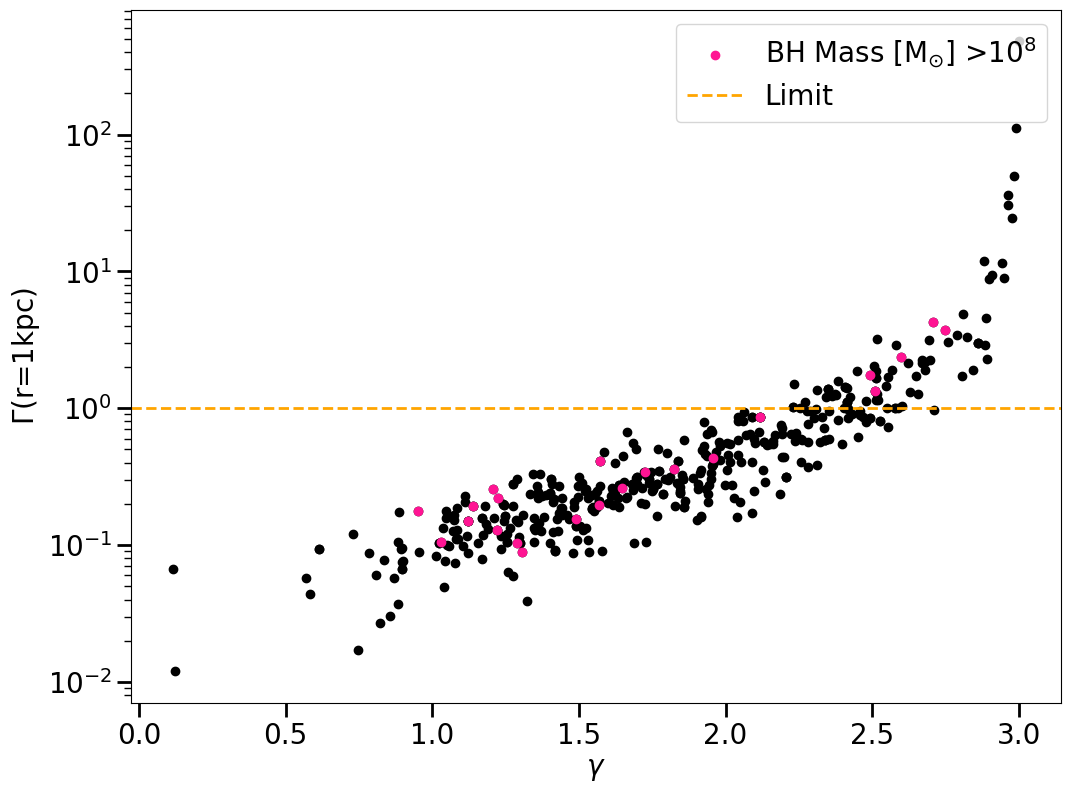

In [21]:
#data_to_file = {'Sim_BH_host_mass':sim_mass,'b':b,'Galaxy_mass':Gal_mass,'time':time,'BH_host_mass':int_mass,'BH_mass':BH_mass,'BH_id':BHid,'Cluster_centre_distance':Cluster_distance,'notes':"All masses are within the unresolved 1kpc"}
#f = open('Host_masses0.7-1.75.pkl','wb')

f = open('Host_masses0.7-1.75.pkl','rb')
data = pck.load(f)
f.close()

mass=np.array(data['BH_host_mass'])
gal_mass=np.array(data['Galaxy_mass'])
B=np.array(data['b'])
y=mass/gal_mass
x=np.array(data['BH_mass'])
ok=np.where(x>10000000)
high_mass=y[ok]
b=B[ok]

new=np.log(high_mass)
a,c=np.polyfit(b,new,1)

#plt.plot(b,a*b+c)

plt.scatter(B,y,c='k')
plt.scatter(b,high_mass,label='BH Mass [M$_{\odot}$] >10$^8$',c='deeppink')
#plt.plot(B,z,ls='--',c='lightblue')
plt.yscale('log')
plt.xlabel('$\gamma$')
plt.ylabel('$\Gamma$(r=1kpc)')
plt.axhline(y=1,label='Limit',c='orange',lw=2,ls='--')
plt.legend(loc='upper right')
plt.savefig('masscheck.png')
np.log10(min(x))
no = np.where(y>1)
print(len(y))

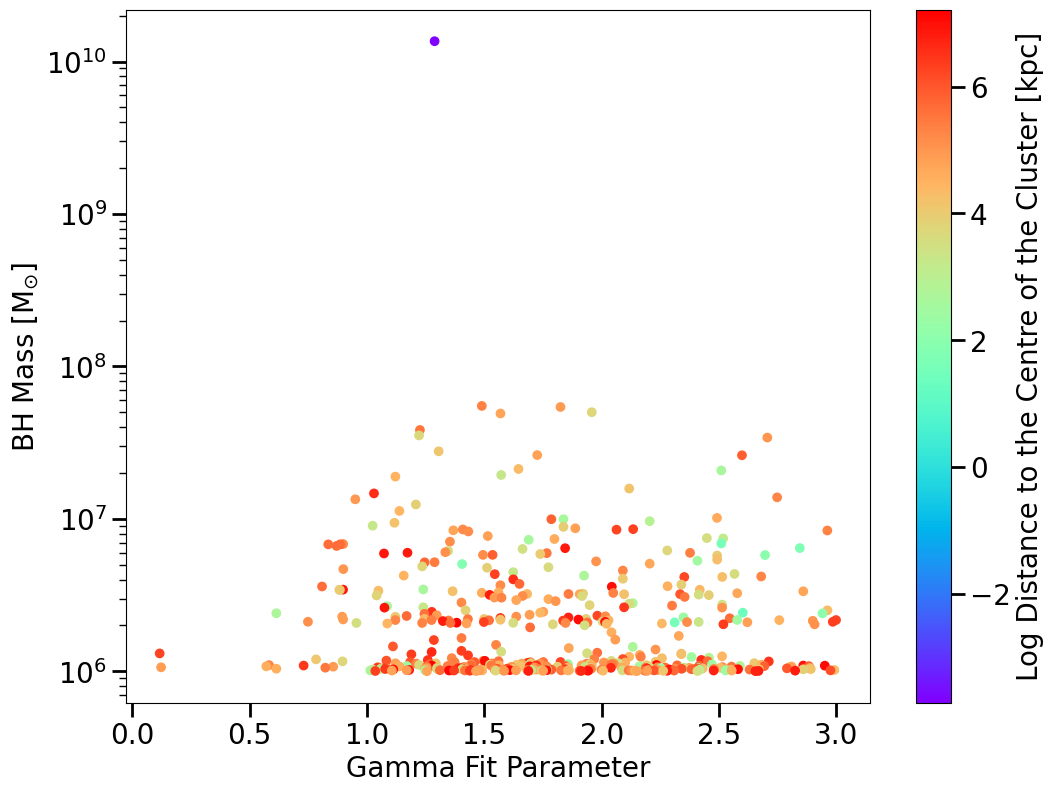

In [9]:
plt.scatter(B,x,c=np.log10(data['Cluster_centre_distance']),cmap = 'rainbow')
plt.ylabel('BH Mass [M$_{\odot}$]')
plt.xlabel('Gamma Fit Parameter')
plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
plt.yscale('log')

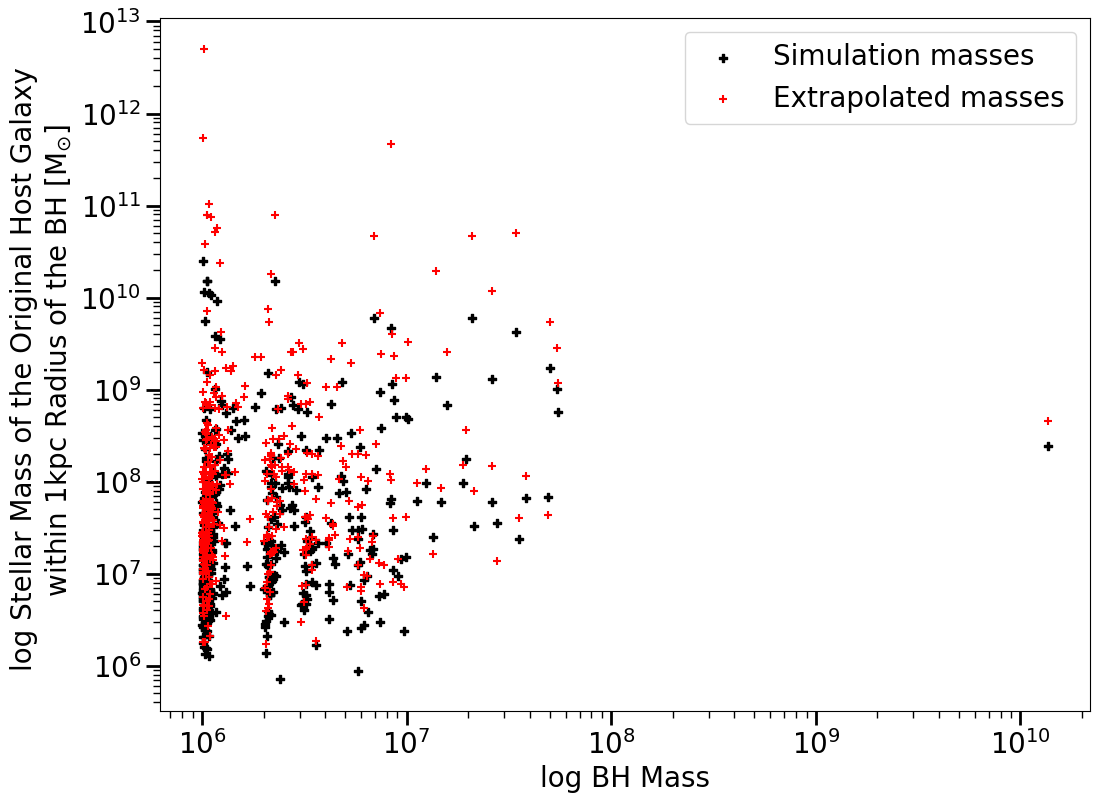

In [138]:
plt.scatter(data['BH_mass'],data['Sim_BH_host_mass'],c='k',marker='P',label='Simulation masses')
plt.scatter(data['BH_mass'],data['BH_host_mass'],c='r',marker='+',label='Extrapolated masses')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('log Stellar Mass of the Original Host Galaxy \n within 1kpc Radius of the BH [M$_{\odot}$]')
plt.xlabel('log BH Mass')
plt.legend(loc='upper right')

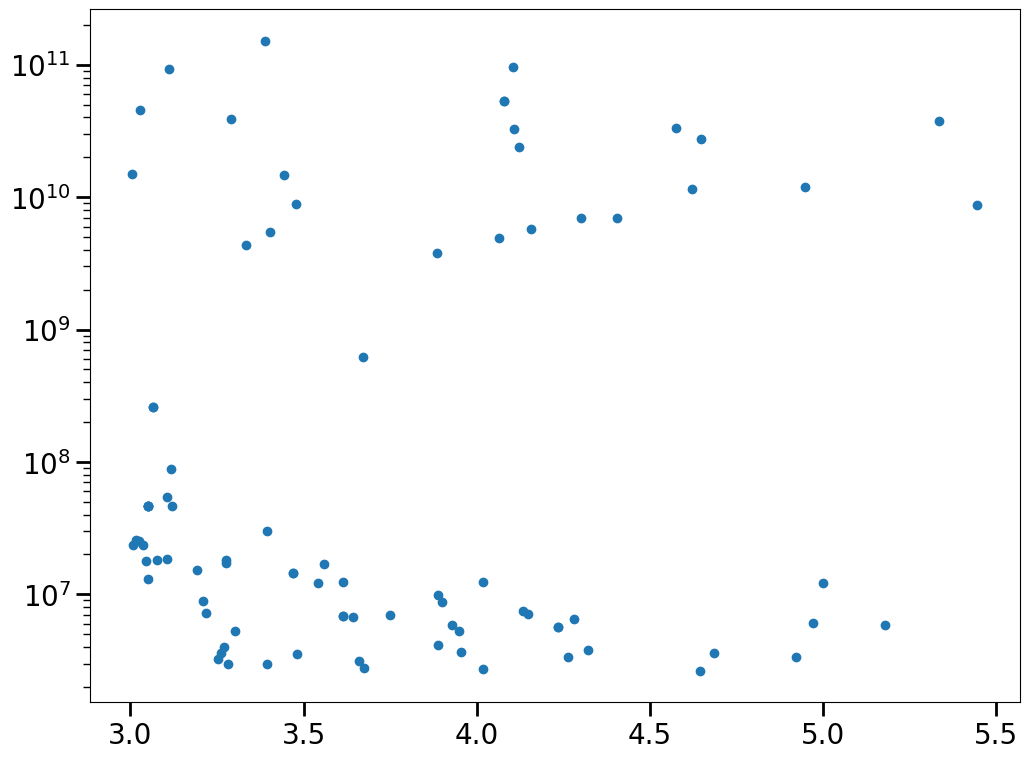

In [15]:
#data_to_file = {'BH_mass':bad_BH_mass,'BH_id':bad_BHid,'Gal_mass':bad_Gal_mass,'Host':bad_host,'time':bad_time,'b':bad_b}
#f = open('Bad_b0.7-1.75.pkl','wb')

f = open('Bad_b0.7-1.75.pkl','rb')
data2 = pck.load(f)
f.close()

mass2=np.array(data2['BH_mass'])
gal_mass2=np.array(data2['Gal_mass'])
B2=np.array(data2['b'])
time =np.array(data2['time'])
plt.scatter(B2,gal_mass2)
plt.yscale('log')

a=[]
for i in range(len(mass2)):
    step['t()']=time[i]
    halo = step.get_halo
    #here for step, get halo at that step, find properties of halo at that step to investivate-density etc 

In [18]:
f = open('Errors.pkl','rb')
data2 = pck.load(f)
f.close()

never_central = np.array(data2['never_central'])
never_left=np.array(data2['never_left'])
no_profile=np.array(data2['no_profile'])
no_density_at_rad=np.array(data2['no_density_at_rad'])
no_sim_mass=np.array(data2['no_sim_mass'])
not_enough_points=np.array(data2['not_enough_points'])
bad_res_host=np.array(data2['bad_res_host'])
inside_cluster=np.array(data2['inside_cluster'])
density_change=np.array(data2['density_change'])
all_three=np.array(data2['all_three'])
                            
all_ids = data['bhid']
ids=[]
bad_indices =[]                            
for i in range(len(all_ids)):
    if not all_ids[i] in bad_res_host:
        ids.append(all_ids[i])
        bad_indices.append(i)
                            
#print(len(bad_res_host))
#print(len(all_ids))
#print(len(ids))
#print(bad_indices)
new = np.arange(0,519,1)
indices = np.delete(new,bad_indices)
#print(indices)

new_b = np.delete(B,indices)
new_x = np.delete(x,indices)
new_dist = np.delete(dist,indices)
new_gal_mass = np.delete(gal_mass,indices)

#plt.scatter(new_b,new_x,c=np.log10(new_dist),cmap = 'rainbow')
#plt.ylabel('BH Mass [M$_{\odot}$]')
#plt.xlabel('Gamma Fit Parameter')
#plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
#plt.yscale('log')
bad_b_ids = []
bad_i=[]
for i in range(len(all_ids)):
    if B[i]>2.999:
        bad_b_ids.append(all_ids[i])
        bad_i.append(i)
#print(bad_i)
#print(all_ids)
#print(bad_b_ids)
#print(B[bad_i])

new_bad_b_ids = []
new_bad_i=[]
bad = np.where(new_b>2.999)
for i in range(len(new_b)):
    if new_b[i]>2.999:
        new_bad_b_ids.append(all_ids[i])
        new_bad_i.append(i)
        
small= np.where(new_gal_mass<1000000000)
big=np.where(new_gal_mass>1000000000)

#for i in range(len(new_bad_b_ids)):
 #   
  #  print(new_bad_b_ids[i])
   # print(new_b[bad][i])

print(len(never_central))
print(len(bad_res_host))
print(never_central[:3])
print(all_ids[:25])


1378
67
[568959818 569038075 568974651]
[568940603, 568941788, 568983956, 568954394, 568947277, 569083338, 568954823, 569034332, 568940390, 568945875, 568946292, 568954059, 568944270, 568965228, 569017643, 569013861, 568952546, 569067207, 569013229, 569025670, 568986813, 569056550, 569019624, 569090566, 568940683]
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo
booboo


568944270
569013861
569025670
569019624
568962235
569085830
569088464
568948028
568969037
569424843
568957355
568961687
569503905
568960772
569439510
569849656
569765363
569366681
569165783
569089532
569680104
569684299
571250560
569378387
569629908
571450061
569738964
569125755
579632101
569893834
569310667
570617201
569116964
569175203
573806525
569250087
569777192
569579053
570274039
570224705


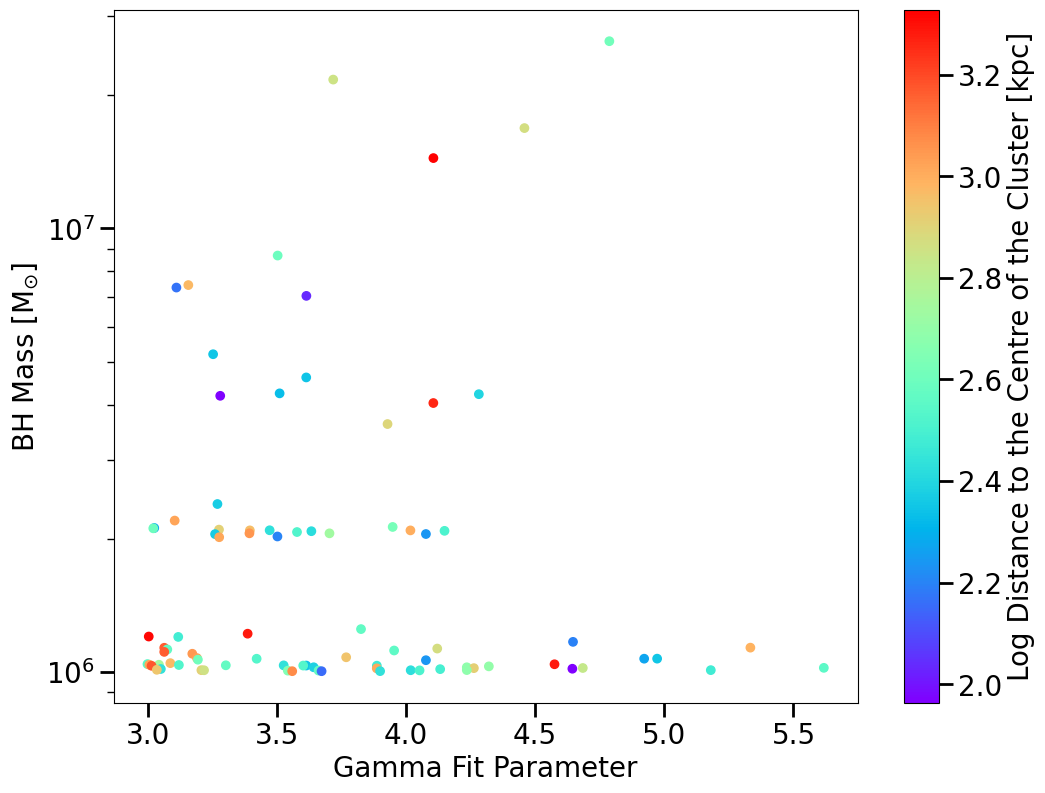

In [7]:
f = open('Outside_halo.pkl','rb')
data = pck.load(f)
f.close()

dist = np.array(data['cluster_dist'])
gal_mass=np.array(data['gal_mass'])
B=np.array(data['gamma'])
x=np.array(data['bh_mass'])
ok = np.where(B>2.999)
#bad = np.where(B>2.9)

plt.scatter(B[ok],x[ok],c=np.log10(dist[ok]),cmap = 'rainbow')
plt.ylabel('BH Mass [M$_{\odot}$]')
plt.xlabel('Gamma Fit Parameter')
plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
plt.yscale('log')

bhids=np.array(data['bhid'])
bad_bhid = bhids[ok]

#print(bad_bhid)
#print(bad_res_host)
for i in range(len(bad_bhid)):
    
    if not bad_bhid[i] in bad_res_host:
        print(bad_bhid[i])
#print(len(B[ok]))
#print(len(B[bad]))
#print(len(data['gamma']))

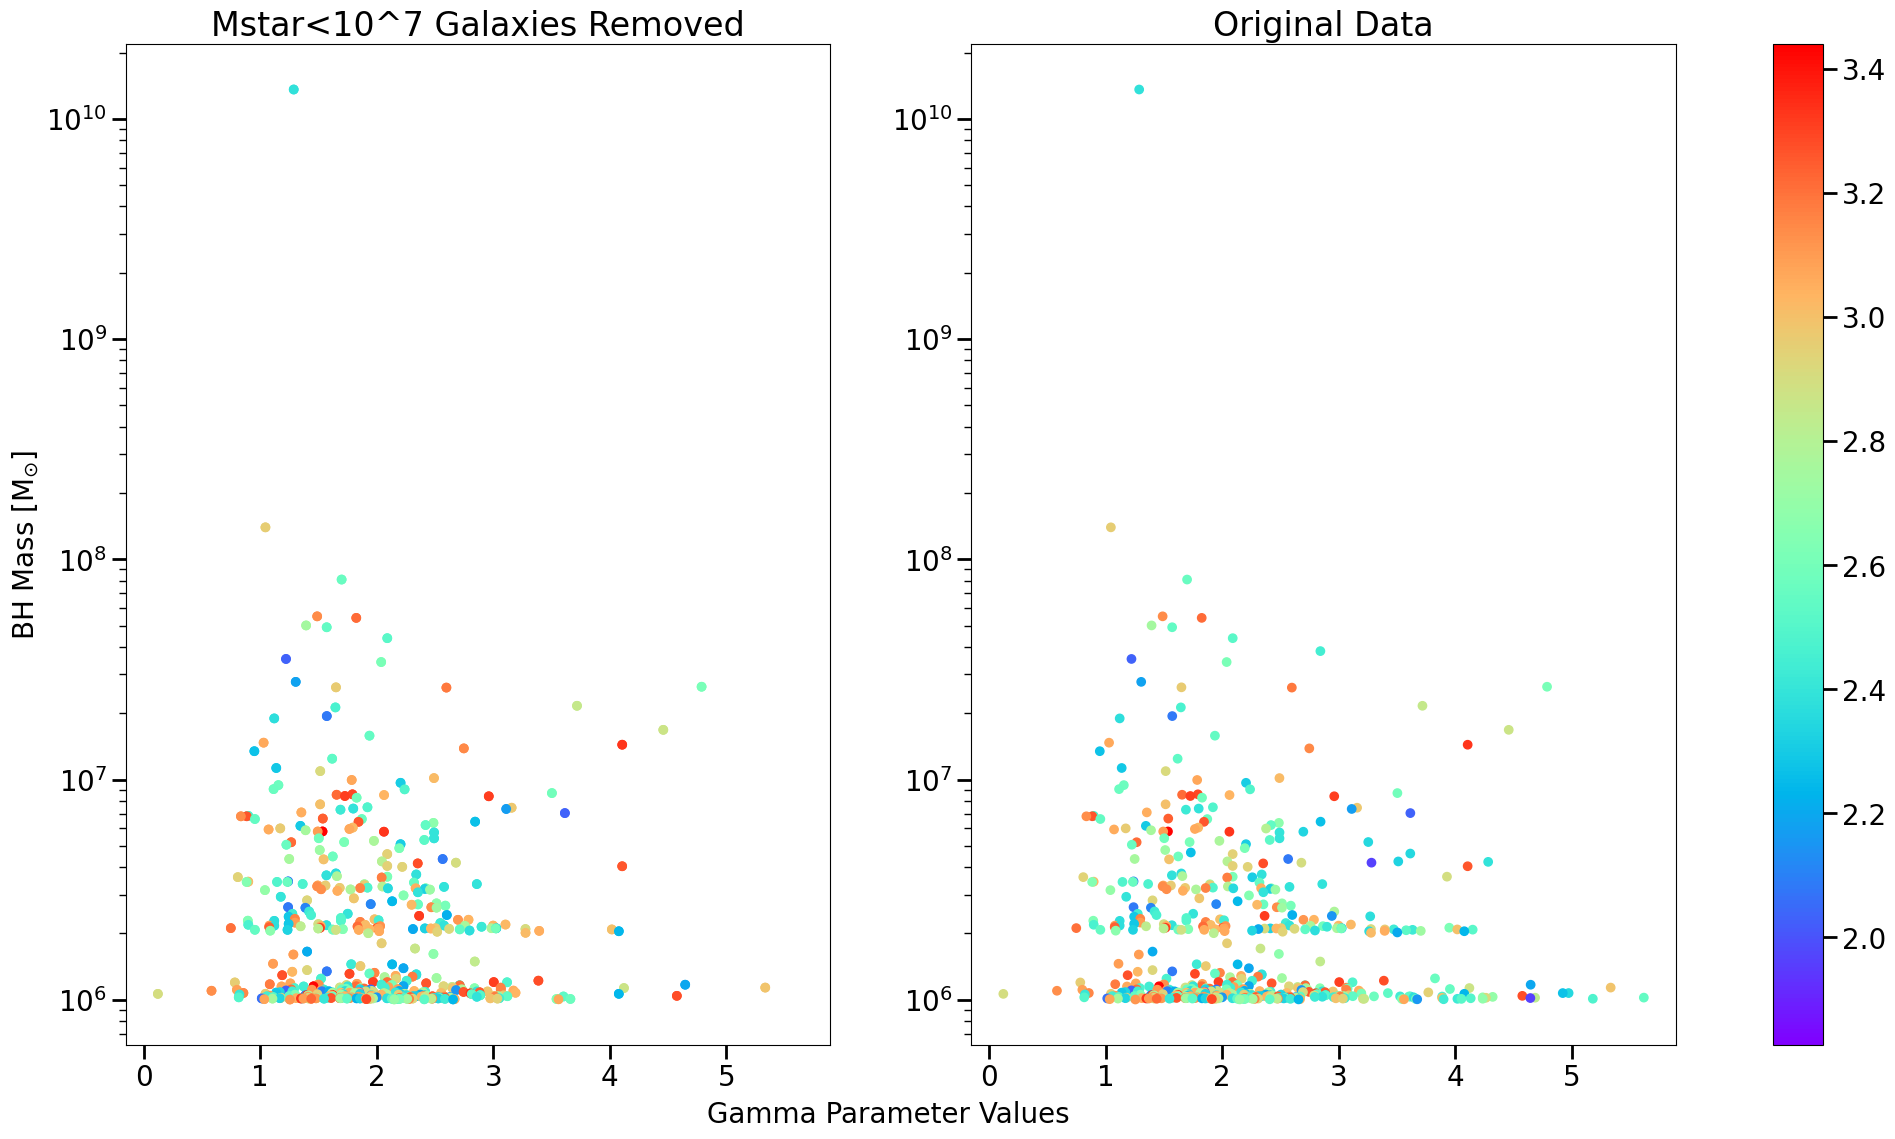

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,13),sharex='all')

ax1.scatter(new_b,new_x,c=np.log10(new_dist),cmap = 'rainbow')
ax1.set_title('Mstar<10^7 Galaxies Removed')
ax1.set_ylabel('BH Mass [M$_{\odot}$]')
#ax1.set_xlabel('g')
ax2.scatter(B,x,c=np.log10(dist),cmap = 'rainbow')
ax2.set_title('Original Data')
ax2.set_yscale('log')
ax1.set_yscale('log')
#ax1.set_xlabel('Gamma Fit Parameter')
#fig.colorbar(cm.ScalarMappable(cmap='rainbow'),label='Log Distance to the Centre of the Cluster [kpc]',location='right')
fig.colorbar(ax1.scatter(new_b,new_x,c=np.log10(new_dist),cmap = 'rainbow'),ax=(ax1,ax2),location='right')
fig.text(0.43,0.05,'Gamma Parameter Values',fontsize=20,ha='center')
plt.show()

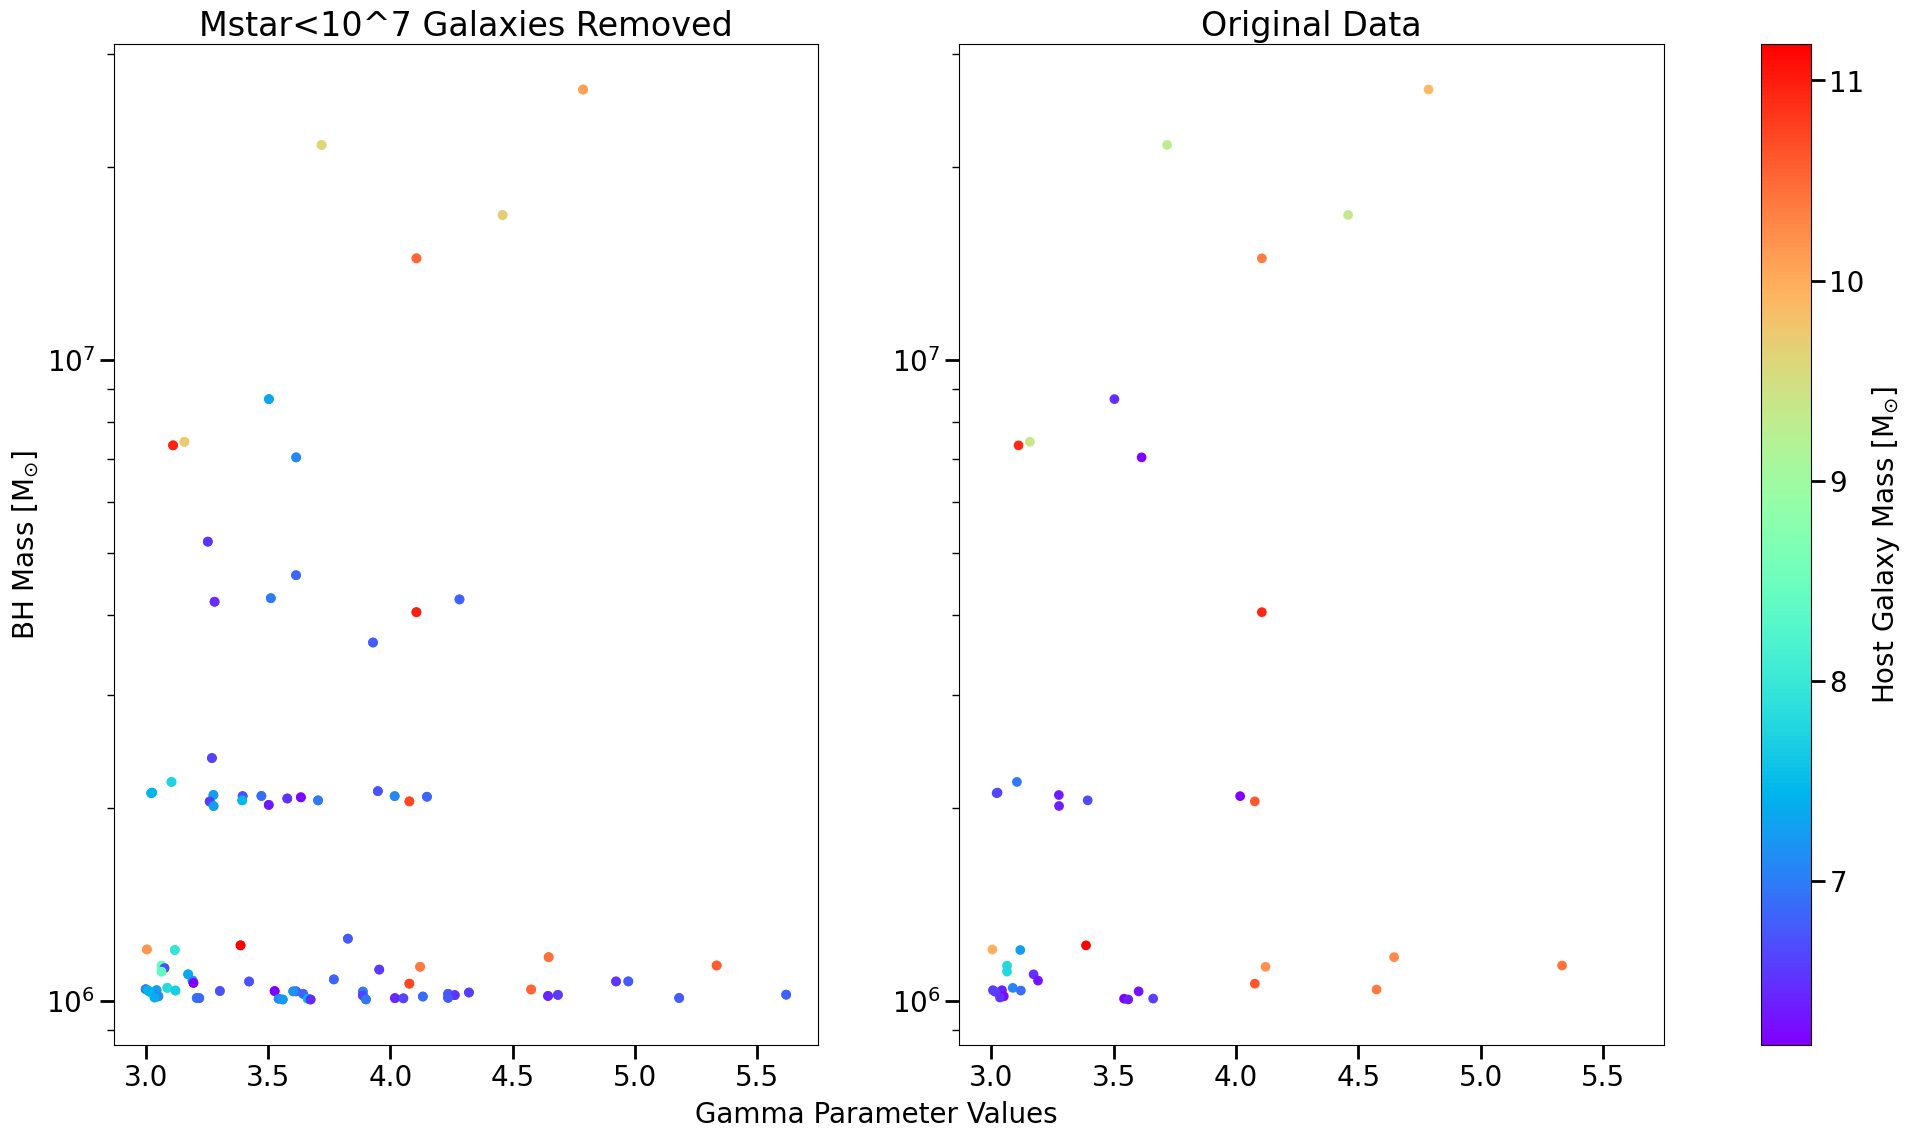

In [80]:
#plt.scatter(B[bad_i],x[bad_i],c=np.log10(gal_mass[bad_i]),cmap = 'rainbow')
#plt.ylabel('BH Mass [M$_{\odot}$]')
#plt.xlabel('Gamma Fit Parameter')
#plt.colorbar(label='Host Galaxy Mass [M$_{\odot}$]')
#plt.yscale('log')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,13),sharex='all')

ax1.scatter(B[bad_i],x[bad_i],c=np.log10(gal_mass[bad_i]),cmap = 'rainbow')
ax1.set_title('Mstar<10^7 Galaxies Removed')
ax1.set_ylabel('BH Mass [M$_{\odot}$]')
#ax1.set_xlabel('g')
ax2.scatter(new_b[new_bad_i],new_x[new_bad_i],c=np.log10(new_gal_mass[new_bad_i]),cmap = 'rainbow')
ax2.set_title('Original Data')
ax2.set_yscale('log')
ax1.set_yscale('log')
#ax1.set_xlabel('Gamma Fit Parameter')
#fig.colorbar(cm.ScalarMappable(cmap='rainbow'),label='Log Distance to the Centre of the Cluster [kpc]',location='right')
fig.colorbar(ax1.scatter(B[bad_i],x[bad_i],c=np.log10(gal_mass[bad_i]),cmap = 'rainbow'),ax=(ax1,ax2),location='right',label='Host Galaxy Mass [M$_{\odot}$]')
fig.text(0.43,0.05,'Gamma Parameter Values',fontsize=20,ha='center')
plt.show()

In [10]:
f = open('Outside_halo.pkl','rb')
data = pck.load(f)
f.close()

a = np.array(data['normal'])
b = np.array(data['gamma'])

bad_mass=[]
mass=[]

bad = np.where(b>2.999)
good = np.where(b<=2.999)

for i in range(len(b)):
    if b[i] > 2.999:
        m = mass_int(a[i],b[i],r_min=0.35)
        bad_mass.append(m)
    else:
        m = mass_int(a[i],b[i],r_min=0.35)
        mass.append(m)
print(mass[:10])


[171321387.6357925, 67150297.20712382, 22408130.097719993, 448796868.6391957, 1042971926.3876204, 191638442.3103448, 370203260.8544028, 784445935.5743396, 2954935.2338109873, 15151922.738979125]


In [78]:
a = np.array(data['normal'])
b = np.array(data['gamma'])

new_mass=[]
new_bad_mass=[]

bad = np.where(b>2.999)
good = np.where(b<=2.999)

for i in range(len(b)):
    if b[i] > 2.999:
        new_m = new_mass_int(a[i],b[i])
        new_bad_mass.append(new_m)
    else:
        new_m = new_mass_int(a[i],b[i])
        new_mass.append(new_m)

0
433


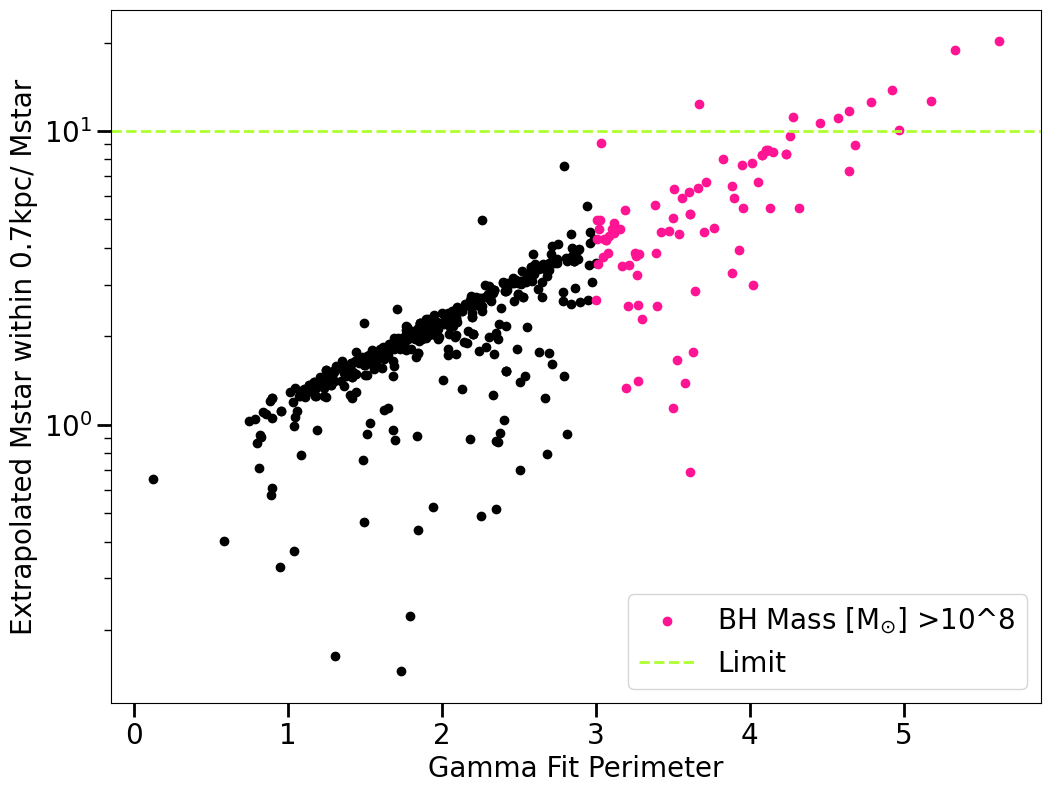

In [97]:
sim_mass= np.array(data['sim_mass'])
bhid=np.array(data['bhid'])
y=mass/gal_mass[good]
z=mass/sim_mass[good]
z2=bad_mass/sim_mass[bad]
y2=bad_mass/gal_mass[bad]

plt.scatter(b[good],z,c='k')
plt.scatter(b[bad],z2,label='BH Mass [M$_{\odot}$] >10^8',c='deeppink')
#plt.plot(B,z,ls='--',c='lightblue')
plt.yscale('log')
plt.xlabel('Gamma Fit Perimeter')
plt.ylabel('Extrapolated Mstar within 0.7kpc/ Mstar')
plt.axhline(y=10,label='Limit',c='greenyellow',lw=2,ls='--')
plt.legend(loc='lower right')

unresonable = np.where(y>1)
print(len(y[unresonable]))
print(len(y))


1
433
30
86


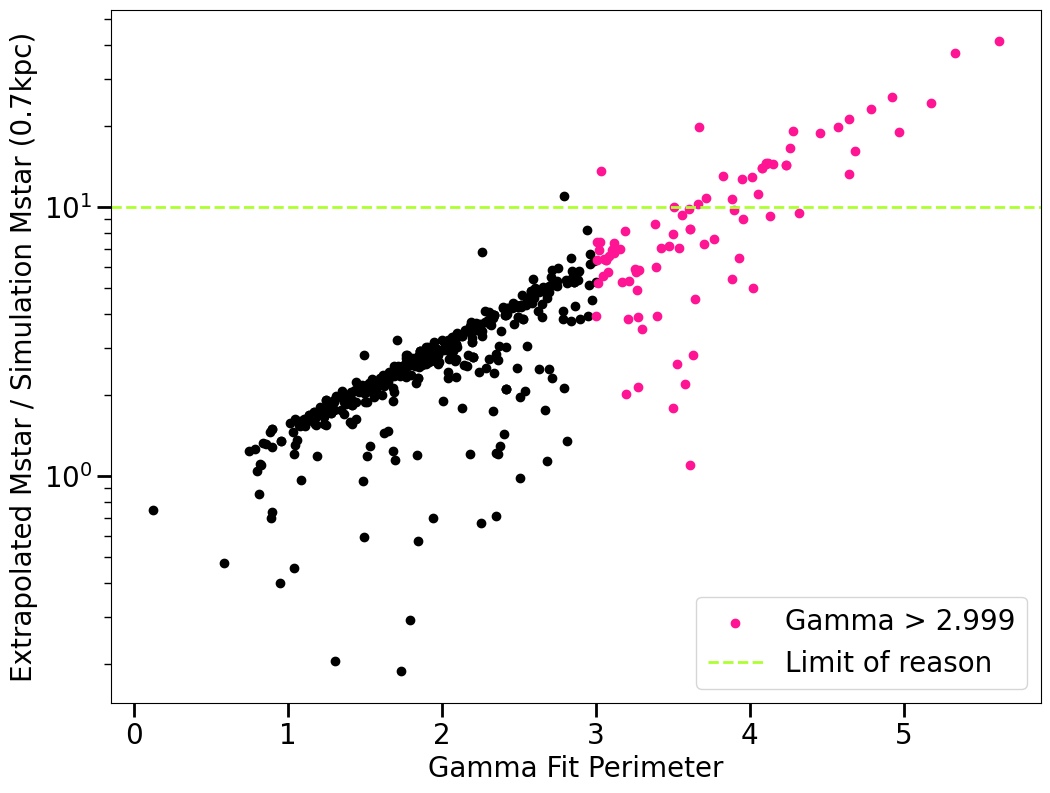

In [103]:
z=new_mass/sim_mass[good]
z2=new_bad_mass/sim_mass[bad]

plt.scatter(b[good],z,c='k')
plt.scatter(b[bad],z2,label='Gamma > 2.999',c='deeppink')
#plt.plot(B,z,ls='--',c='lightblue')
plt.yscale('log')
plt.xlabel('Gamma Fit Perimeter')
plt.ylabel('Extrapolated Mstar / Simulation Mstar (0.7kpc)')
plt.axhline(y=10,label='Limit of reason',c='greenyellow',lw=2,ls='--')
plt.legend(loc='lower right')

no = np.where(z>10)
no2 = np.where(z2>10)
print(len(z[no]))
print(len(z))
print(len(z2[no2]))
print(len(z2))

8
433
66
86


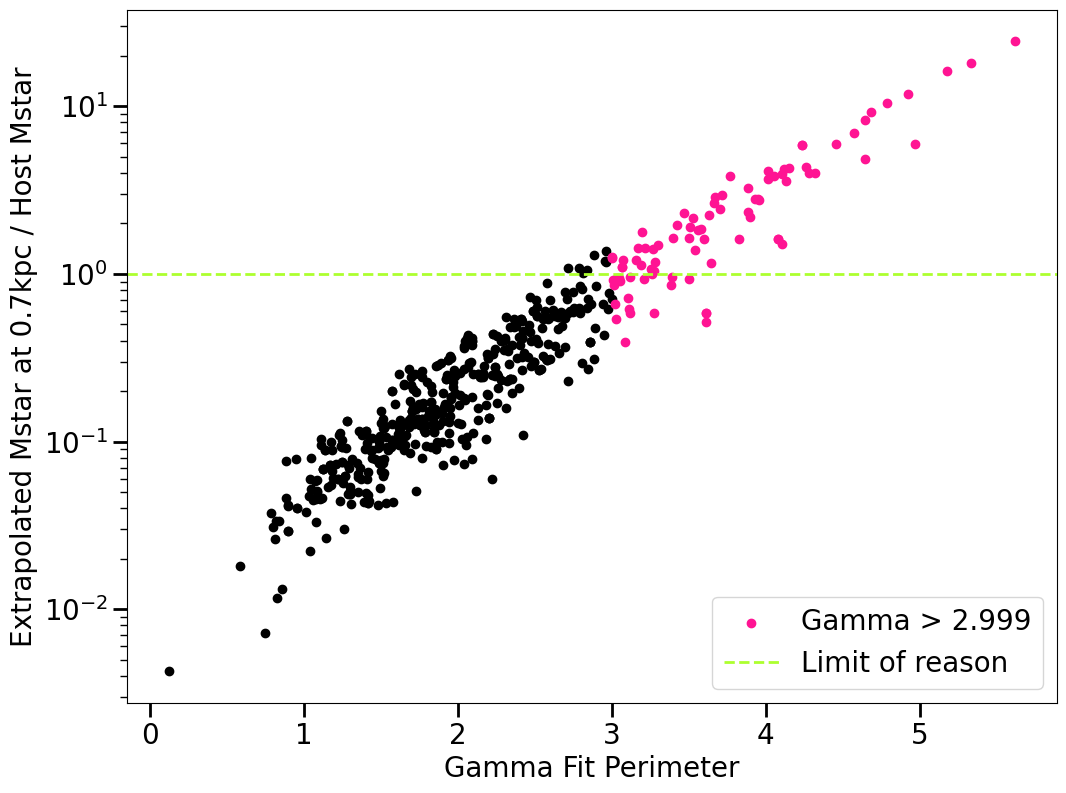

In [105]:
y2=new_bad_mass/gal_mass[bad]
y=new_mass/gal_mass[good]

plt.scatter(b[good],y,c='k')
plt.scatter(b[bad],y2,label='Gamma > 2.999',c='deeppink')
#plt.plot(B,z,ls='--',c='lightblue')
plt.yscale('log')
plt.xlabel('Gamma Fit Perimeter')
plt.ylabel('Extrapolated Mstar at 0.7kpc / Host Mstar')
plt.axhline(y=1,label='Limit of reason',c='greenyellow',lw=2,ls='--')
plt.legend(loc='lower right')

unresonable = np.where(y>1)
print(len(y[unresonable]))
print(len(y))
unresonable = np.where(y2>1)
print(len(y2[unresonable]))
print(len(y2))

Text(0, 0.5, 'Extrapolated Host Galaxy Mstar at 0.7kpc [M$_{\\odot}$]')

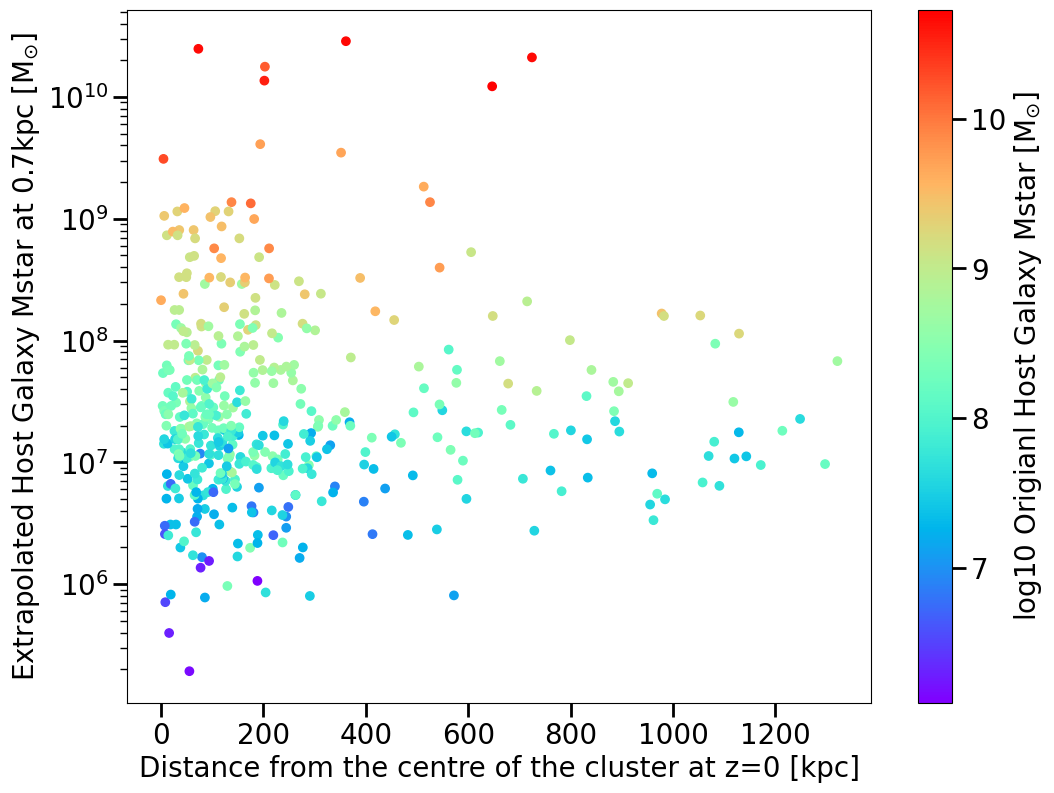

In [119]:

plt.scatter(central_dist[good],new_mass,c=np.log10(gal_mass[good]),cmap='rainbow')
plt.yscale('log')
plt.colorbar(label='log10 Origianl Host Galaxy Mstar [M$_{\odot}$]')
plt.xlabel('Distance from the centre of the cluster at z=0 [kpc]')
plt.ylabel('Extrapolated Host Galaxy Mstar at 0.7kpc [M$_{\odot}$]')

Text(0, 0.5, 'Extrapolated Mstar at 0.7kpc / Mstar')

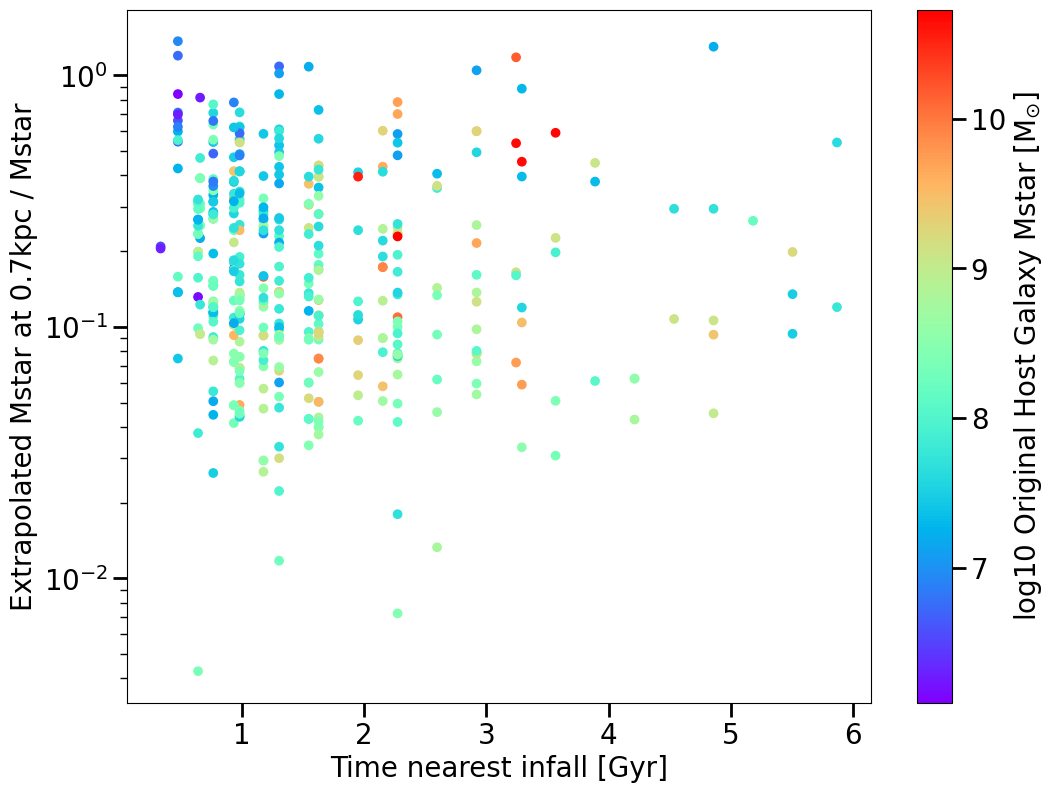

In [165]:
new_ma = np.array(new_mass)
p = new_ma/gal_mass[good]

plt.scatter(infall_time[good],p,c=np.log10(gal_mass[good]),cmap='rainbow')
plt.yscale('log')
plt.colorbar(label='log10 Original Host Galaxy Mstar [M$_{\odot}$]')
plt.xlabel('Time nearest infall [Gyr]')
plt.ylabel('Extrapolated Mstar at 0.7kpc / Mstar')

Text(0, 0.5, 'Extrapolated Host Galaxy Mstar at 0.7kpc [M$_{\\odot}$]')

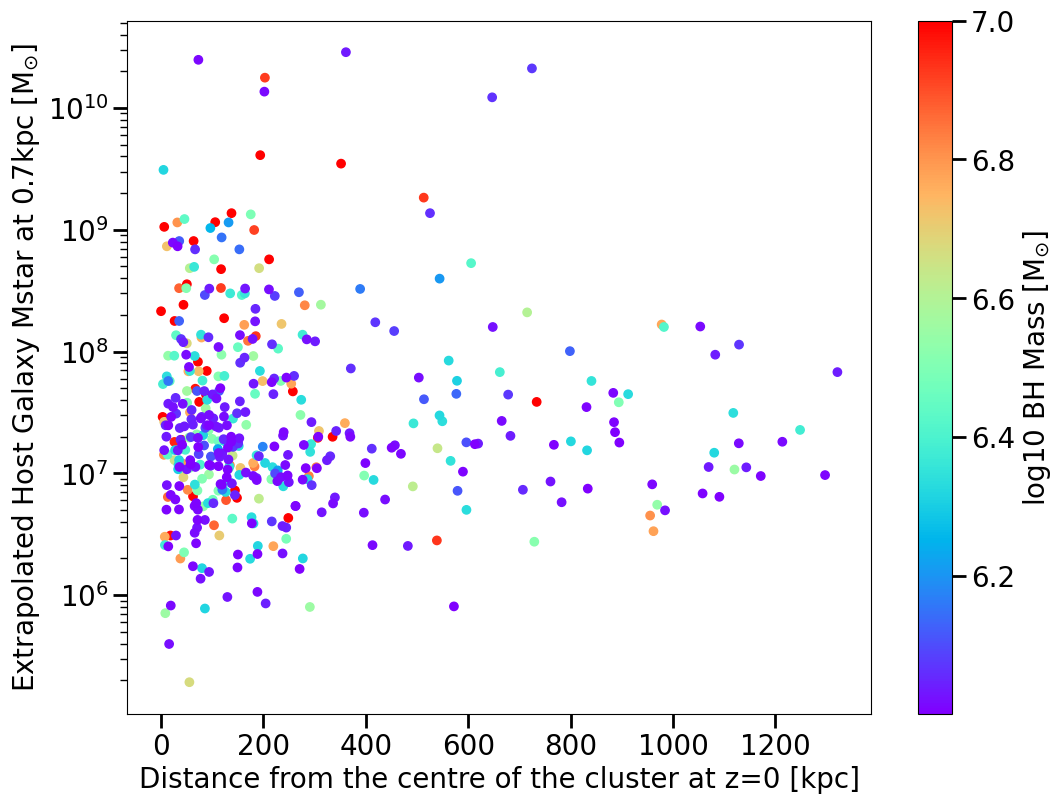

In [136]:
plt.scatter(central_dist[good],new_mass,c=np.log10(x[good]),cmap='rainbow',vmax =7)
plt.yscale('log')
plt.colorbar(label='log10 BH Mass [M$_{\odot}$]')
plt.xlabel('Distance from the centre of the cluster at z=0 [kpc]')
plt.ylabel('Extrapolated Host Galaxy Mstar at 0.7kpc [M$_{\odot}$]')

In [110]:
central_dist=[]
for i in range(len(bhid)):
    bh=db.get_halo('h1.cosmo50/%4096/BH_'+str(bhid[i]))
    dist = bh['BH_central_distance']
    central_dist.append(dist)
                

Text(0, 0.5, 'Original Host Galaxy Mstar [M$_{\\odot}$]')

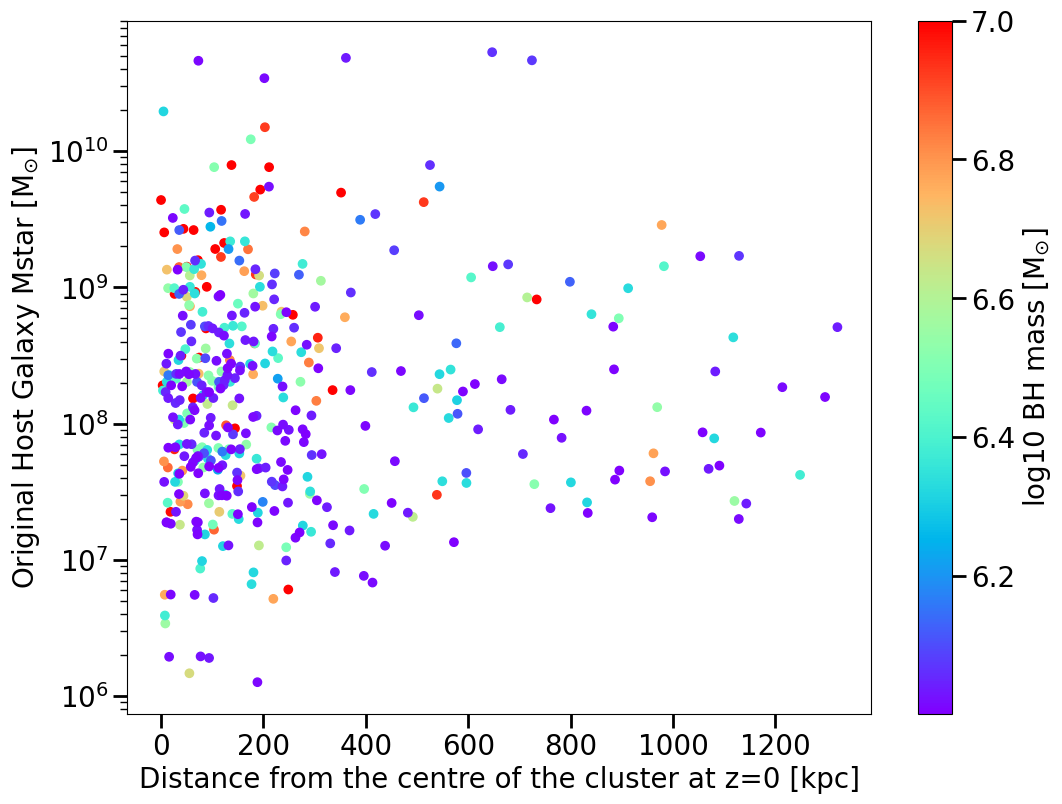

In [111]:
central_dist=np.array(central_dist)

plt.scatter(central_dist[good],gal_mass[good],c=np.log10(x[good]),cmap='rainbow',vmax=7)
plt.yscale('log')
plt.colorbar(label='log10 BH mass [M$_{\odot}$]')
plt.xlabel('Distance from the centre of the cluster at z=0 [kpc]')
plt.ylabel('Original Host Galaxy Mstar [M$_{\odot}$]')
#print(len(dist))
#plt.savefig("gal_m_dist_bhmass.png") 
#f=np.where(dist>2000)
#print(dist[f])
#print(bhid[f])

Text(0, 0.5, 'BH mass z=0 [M$_{\\odot}$]')

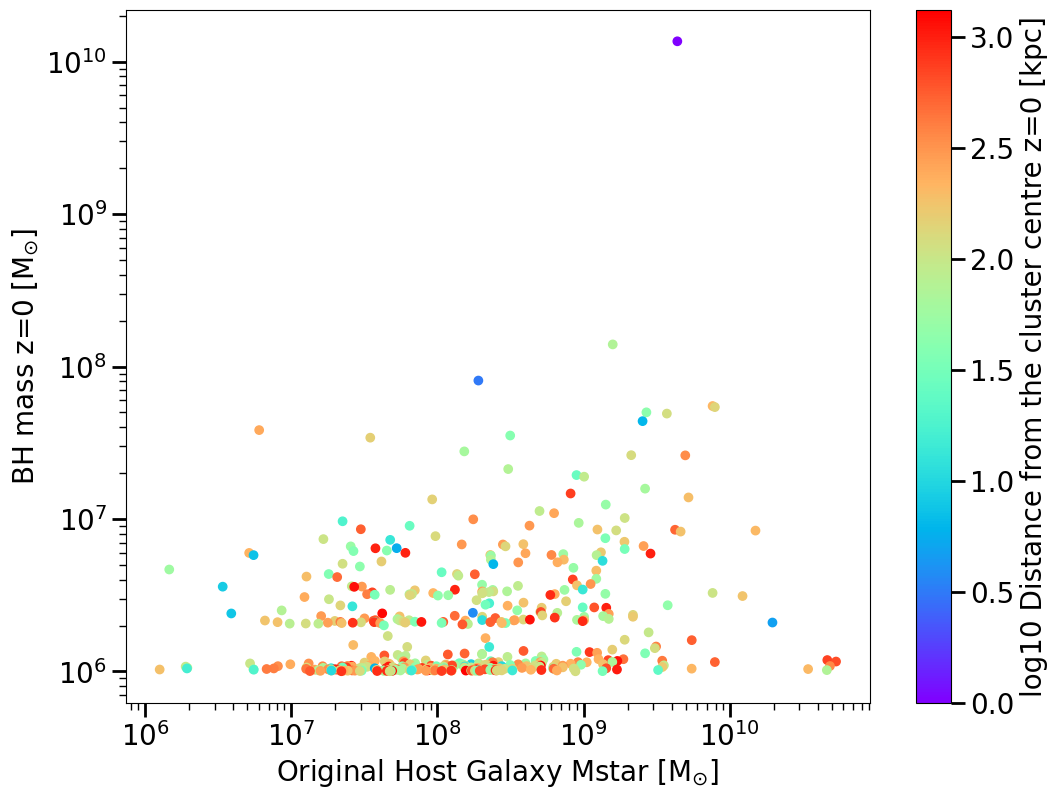

In [29]:
plt.scatter(gal_mass[good],x[good],c=np.log10(central_dist[good]),cmap='rainbow',vmin=0)
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='log10 Distance from the cluster centre z=0 [kpc]')
plt.xlabel('Original Host Galaxy Mstar [M$_{\odot}$]')
plt.ylabel('BH mass z=0 [M$_{\odot}$]')

In [ ]:
host_density(1,0)

In [137]:
time= data['time'][0]
#print(time)
#print(data['time'][0])
time.gather_property('t()')
time = []
for i in range(len(data['time'])):
    t = data['time'][i].gather_property('t()')[0][0]
    time.append(t)
    

In [155]:
to_file = {'time':time}
f=open('infall_time1.pkl','wb')
pck.dump(to_file,f)
f.close()


In [15]:
f=open('infall_time1.pkl','rb')
infall=pck.load(f)
f.close()

infall_time=np.array(infall['time'])
print(min(infall_time))
print(infall_time[:20])

0.33486441777877685
[0.98122921 1.54679839 0.76577428 1.62759399 2.15276538 1.3044116
 1.62759399 0.93409844 0.47625672 0.98122921 0.93409844 1.95077639
 2.92032357 1.95077639 2.27395878 1.62759399 0.76577428 0.6412144
 0.98122921 1.95077639]


483
519


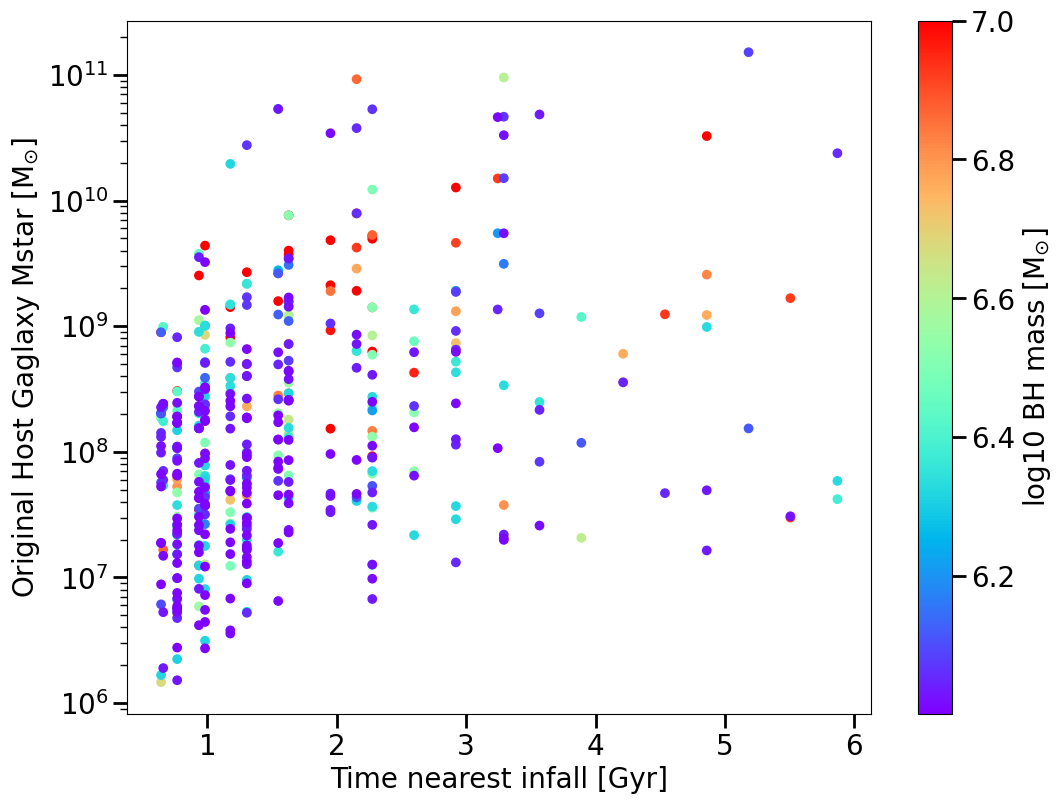

In [154]:
ugh = np.where(infall_time>0.6)

plt.scatter(infall_time[ugh],gal_mass[ugh],c=np.log10(x[ugh]),cmap='rainbow',vmax=7)
plt.yscale('log')
plt.colorbar(label='log10 BH mass [M$_{\odot}$]')
plt.ylabel('Original Host Gaglaxy Mstar [M$_{\odot}$]')
plt.xlabel('Time nearest infall [Gyr]')
#print(len(dist))
#plt.savefig("gal_m_dist_bhmass.png") 
#print(dist[f])

print(len(infall_time[ugh]))
print(len(infall_time))

Text(0, 0.5, 'Time nearest infall [Gyr]')

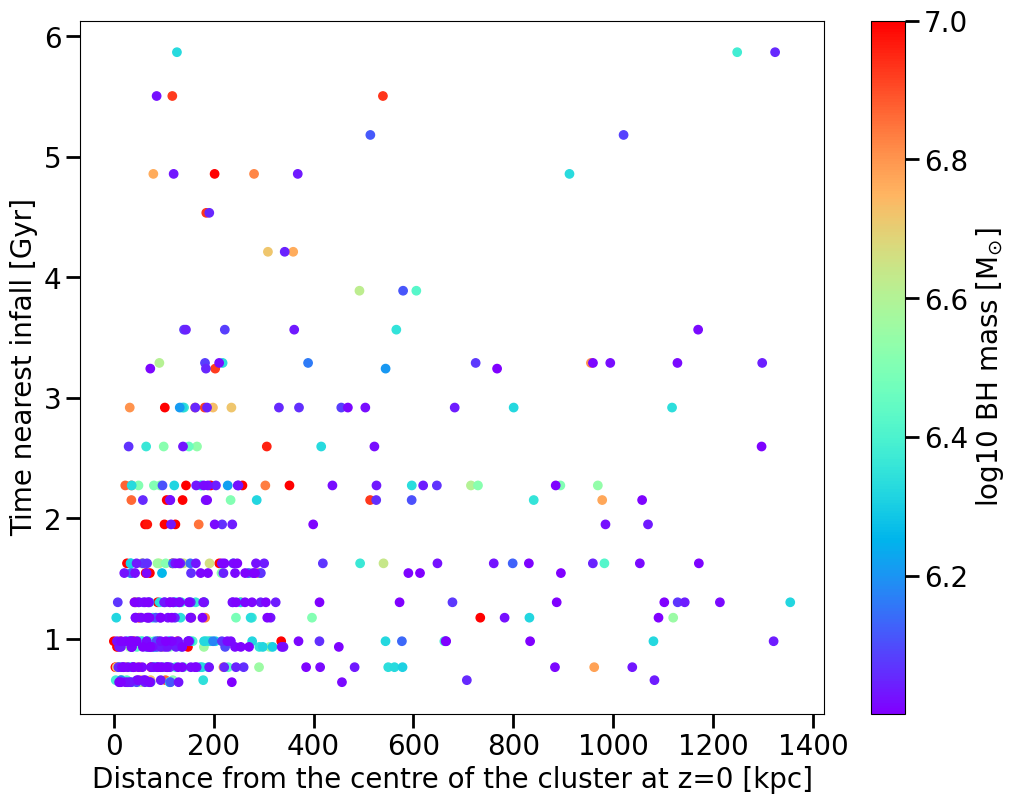

In [53]:
plt.scatter(central_dist[ugh],infall_time[ugh],c=np.log10(x[ugh]),cmap='rainbow',vmax=7)
plt.colorbar(label='log10 BH mass [M$_{\odot}$]')
plt.xlabel('Distance from the centre of the cluster at z=0 [kpc]')
plt.ylabel('Time nearest infall [Gyr]')

Text(0, 0.5, 'Time nearest infall [Gyr]')

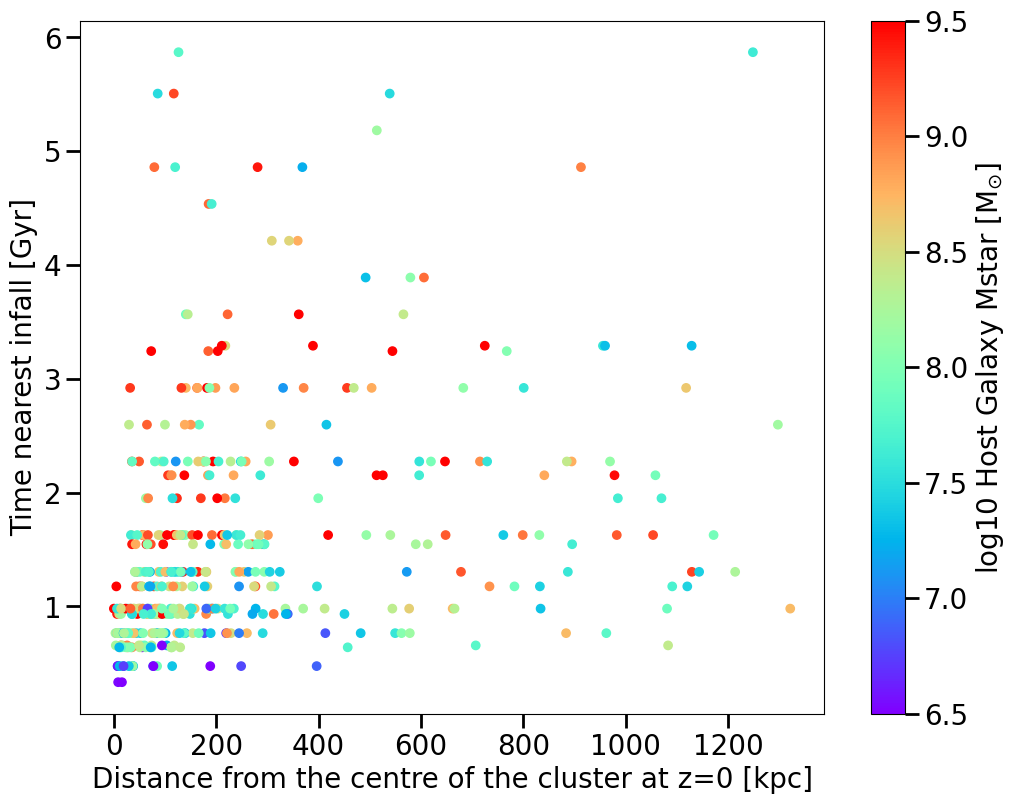

In [43]:
plt.scatter(central_dist[good],infall_time[good],c=np.log10(gal_mass[good]),cmap='rainbow',vmax=9.5,vmin=6.5)
plt.colorbar(label='log10 Host Galaxy Mstar [M$_{\odot}$]')
plt.xlabel('Distance from the centre of the cluster at z=0 [kpc]')
plt.ylabel('Time nearest infall [Gyr]')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


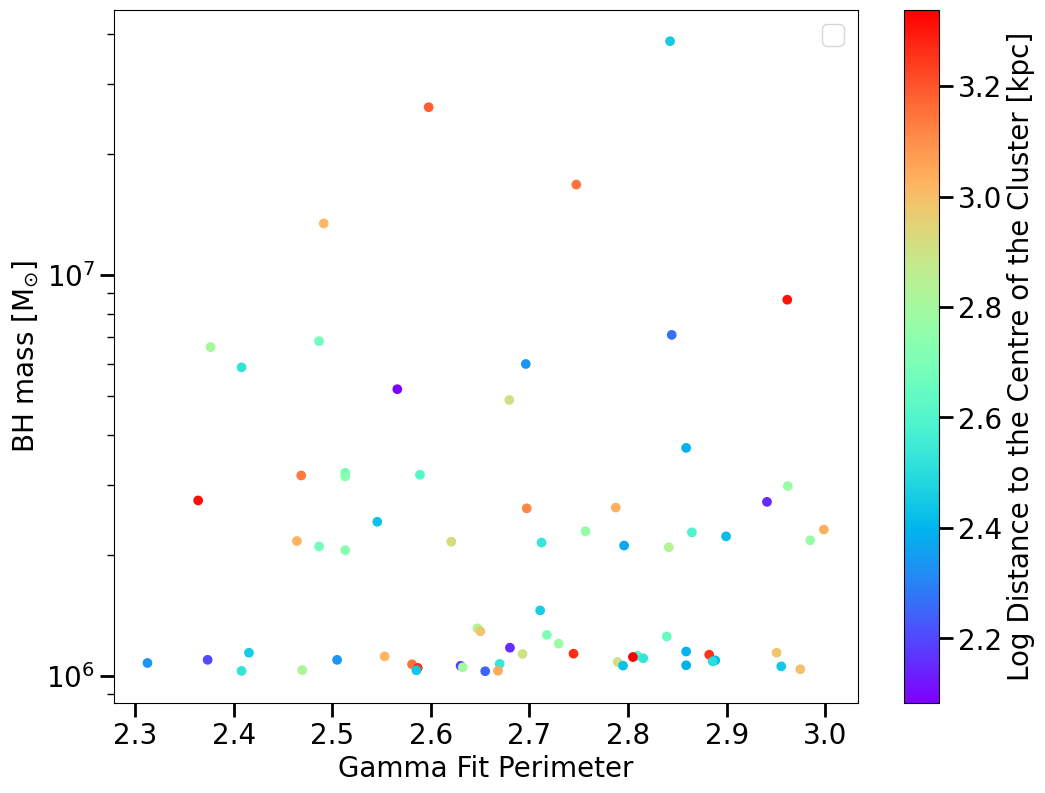

In [21]:
plt.scatter(b[good][unresonable],x[unresonable],c=np.log10(dist[good][unresonable]),cmap = 'rainbow')
#plt.scatter(b[bad],y2,label='BH Mass [M$_{\odot}$] >10^8',c='deeppink')
#plt.plot(B,z,ls='--',c='lightblue')
plt.yscale('log')
plt.xlabel('Gamma Fit Perimeter')
plt.ylabel('BH mass [M$_{\odot}$]')
plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
#plt.axhline(y=1,label='Limit',c='greenyellow',lw=2,ls='--')
plt.legend(loc='upper right')

In [4]:
f = open('ErrorIDS.pkl','rb')
my_saved_data = pck.load(f)
f.close()
ids=my_saved_data['bad_id']

halo = db.get_halo('h1.cosmo50/%4096/1')
all_bhs_h1 = halo['BH_central']
all_ids = []

error_indices = []

for i in range(2193):
    
    all_ids.append(all_bhs_h1[i].halo_number)
    
for i in range(2193):
    if all_ids[i] in ids:
        error_indices.append(i)
        
h1_ids = np.arange(0,2193,1) 

new_ids = np.delete(h1_ids,error_indices)
print(len(new_ids))

KeyError: 'bad_id'

In [3]:


bad_id =[]


gal_mass=[]
halo=[]
bh_mass=[]
BHid=[]
sim_mass=[]
time=[]
distance=[]
a=[]
b=[]

for i in range(2193):
        
    A,B,full_mass,original_mass,mass,bhid,original_halo,step,dist,res,inside,zero = host_density(1,i)
      
    if A == -1 or A == 0 :
        bad_id.append(bhid)
        pass
    
    else: 
            
        a.append(A)
        b.append(B)
        gal_mass.append(full_mass)
        halo.append(original_halo)
        bh_mass.append(mass)
        BHid.append(bhid)
        sim_mass.append(original_mass)
        time.append(step)
        distance.append(dist)
    
    print('N:',i)
    
data_to_file = {'normal':a,'gamma':b,'gal_mass':gal_mass,'halo_num':halo,'bh_mass':bh_mass,'bhid':BHid,'sim_mass':sim_mass,'time':time,'cluster_dist':distance}
#'BH_mass':BH_mass,'BH_id':BHid,'Cluster_centre_distance':Cluster_distance}
f = open('Outside_halo.pkl','wb')
pck.dump(data_to_file,f)
f.close()

data_to_file = {'ids':bad_id}
f = open('ErrorIDS.pkl','wb')
pck.dump(data_to_file,f)
f.close()

#print('\nZero density detected:',density_change,'\nNever left halo1:',never_left,'\nHad no density profile:',no_profile,'\nDidnt have enough density points:',not_enough_points,'\nHad no density within the given radius:',no_density_at_rad)
#Cluster_distance.append(dist)
    #BHid.append(bhid)
    #BH_mass.append(bh_mass)

Original BH Host: 3
BH id: 568940603
Time in simulation: 0.9812292056226746 Gyr
N: 0


/tmp/ipykernel_436947/3188402957.py:176: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


Original BH Host: 68
BH id: 568941788
Time in simulation: 1.5467983949884065 Gyr
N: 1
Original BH Host: 22
BH id: 568983956
Time in simulation: 0.7657742763411864 Gyr
N: 2
Original BH Host: 10
BH id: 568954394
Time in simulation: 1.627593993470575 Gyr
N: 3
Original BH Host: 51
BH id: 568947277
Time in simulation: 2.152765383604354 Gyr
N: 4
Original BH Host: 13
BH id: 569083338
Time in simulation: 1.3044115995449361 Gyr
N: 5
Original BH Host: 21
BH id: 568954823
Time in simulation: 1.627593993470575 Gyr
N: 6
Original BH Host: 7
BH id: 569034332
Time in simulation: 0.9340984398422605 Gyr
N: 7
ERROR: no original host
N: 8
Original BH Host: 86
BH id: 568945875
Time in simulation: 0.9812292056226746 Gyr
N: 9


/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/live_calculation/__init__.py:616: RuntimeWarning: More than one relation for target 'host_halo' has been found. Picking the first.
  warnings.warn("More than one relation for target %r has been found. Picking the first."%str(self.locator), RuntimeWarning)


Original BH Host: 183
BH id: 568946292
Time in simulation: 0.9340984398422605 Gyr
N: 10
ERROR: host galaxy not resolved
N: 11
Original BH Host: 2896
BH id: 568954059
Time in simulation: 1.9507763873998631 Gyr
N: 12
Original BH Host: 42
BH id: 568944270
Time in simulation: 2.920323569180768 Gyr
N: 13
Original BH Host: 66
BH id: 568965228
Time in simulation: 1.9507763873998631 Gyr
N: 14
Original BH Host: 44
BH id: 569017643
Time in simulation: 2.273958781327042 Gyr
N: 15
Original BH Host: 26
BH id: 569013861
Time in simulation: 1.627593993470575 Gyr
N: 16
Original BH Host: 14
BH id: 568952546
Time in simulation: 0.7657742763411864 Gyr
N: 17
ERROR the BH never met the three conditions
N: 18
ERROR: host galaxy not resolved
N: 19
ERROR: no original host
N: 20
Original BH Host: 12
BH id: 569013229
Time in simulation: 0.9812292056226746 Gyr
N: 21
Original BH Host: 30
BH id: 569025670
Time in simulation: 1.9507763873998631 Gyr
N: 22
ERROR: This BH was never central
N: 23
Original BH Host: 44
B

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_hnnv, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


Original BH Host: 3151
BH id: 569105031
Time in simulation: 3.2906367288932645 Gyr
N: 1194
ERROR: This BH was never central
N: 1195
ERROR: This BH was never central
N: 1196
ERROR: This BH was never central
N: 1197
ERROR: This BH was never central
N: 1198
ERROR: This BH was never central
N: 1199
ERROR: This BH was never central
N: 1200
ERROR: This BH was never central
N: 1201
ERROR: This BH was never central
N: 1202
ERROR: This BH was never central
N: 1203
ERROR: This BH was never central
N: 1204
ERROR: This BH was never central
N: 1205
ERROR: This BH was never central
N: 1206
ERROR: This BH was never central
N: 1207
ERROR: This BH was never central
N: 1208
ERROR: This BH was never central
N: 1209
ERROR the BH never met the three conditions
N: 1210
ERROR: This BH was never central
N: 1211
Original BH Host: 3316
BH id: 568953435
Time in simulation: 1.3044115995449361 Gyr
N: 1212
ERROR: This BH was never central
N: 1213
ERROR: This BH was never central
N: 1214
ERROR: host galaxy not resol

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_wfby, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
N: 1275
ERROR: This BH was never central
N: 1276
ERROR: This BH was never central
N: 1277
ERROR: host galaxy not resolved
N: 1278
ERROR: This BH was never central
N: 1279
ERROR: This BH was never central
N: 1280
ERROR: This BH was never central
N: 1281
ERROR: This BH was never central
N: 1282
ERROR: This BH was never central
N: 1283
ERROR: This BH was never central
N: 1284
ERROR: host galaxy not resolved
N: 1285
ERROR: This BH was never central
N: 1286
ERROR: This BH was never central
N: 1287
ERROR: This BH was never central
N: 1288
ERROR: This BH was never central
N: 1289
ERROR: This BH was never central
N: 1290
ERROR: This BH was never central
N: 1291
ERROR: host galaxy not resolved
N: 1292
Original BH Host: 211
BH id: 569422302
Time in simulation: 1.1764852352842392 Gyr
N: 1293
ERROR: This BH was never central
N: 1294
Original BH Host: 351
BH id: 569769247
Time in simulation: 1.3044115995449361 Gyr
N: 1295
ERROR: This BH was never central
N: 1296
Ori

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_xfjj, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
N: 2037
ERROR: This BH was never central
N: 2038
ERROR: This BH was never central
N: 2039
ERROR: This BH was never central
N: 2040
ERROR: This BH was never central
N: 2041
ERROR: This BH was never central
N: 2042
ERROR: This BH was never central
N: 2043
ERROR: This BH was never central
N: 2044
ERROR: This BH was never central
N: 2045
ERROR: This BH was never central
N: 2046
ERROR: This BH was never central
N: 2047
ERROR: This BH was never central
N: 2048
ERROR: This BH was never central
N: 2049
ERROR: This BH was never central
N: 2050
ERROR: This BH was never central
N: 2051
ERROR: This BH was never central
N: 2052
ERROR: This BH was never central
N: 2053
ERROR: This BH was never central
N: 2054
ERROR: This BH was never central
N: 2055
ERROR: This BH was never central
N: 2056
ERROR: This BH was never central
N: 2057
ERROR: host galaxy not resolved
N: 2058
ERROR: This BH was never central
N: 2059
ERROR: This BH was never central
N: 2060
ERROR: This BH wa

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_bcma, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
N: 2066
ERROR: This BH was never central
N: 2067
ERROR: This BH was never central
N: 2068
ERROR: This BH was never central
N: 2069
ERROR: This BH was never central
N: 2070
ERROR: This BH was never central
N: 2071
ERROR: This BH was never central
N: 2072
ERROR: This BH was never central
N: 2073
ERROR: This BH was never central
N: 2074
ERROR: This BH was never central
N: 2075
ERROR: This BH was never central
N: 2076
ERROR: This BH was never central
N: 2077
ERROR: This BH was never central
N: 2078
ERROR: This BH was never central
N: 2079
ERROR: This BH was never central
N: 2080
ERROR: This BH was never central
N: 2081
ERROR: This BH was never central
N: 2082
ERROR: This BH was never central
N: 2083
ERROR: This BH was never central
N: 2084
ERROR: This BH was never central
N: 2085
ERROR: This BH was never central
N: 2086
ERROR: This BH was never central
N: 2087
ERROR: This BH was never central
N: 2088
ERROR: This BH was never central
N: 2089
ERROR: This BH w

In [33]:
f = open('test.pkl','rb')
test = pck.load(f)
f.close()

f = open('Error_test.pkl','rb')
test2 = pck.load(f)
f.close()

print(test['bhid'])
print(test2['inside_cluster'])
print(test2['no_density_at_rad'])
print(test['gamma'])

[568940603, 568941788, 568983956, 568954394, 568947277, 569083338, 568954823, 569034332, 568940390, 568945875, 568946292]
[568941788, 568983956, 569083338, 568954823, 569034332, 568940390, 568946292]
[568974471]
[1.2879473355374316, 1.0451748510086454, 1.6989362333905076, 1.4892033268877451, 1.8244272480763661, 1.3942682222701466, 1.5708665958936698, 2.0904844666091855, 2.842577522847201, 1.2217404116904016, 2.0382968364137213]


In [9]:
f = open('Host_Masses15.pkl','rb')
my_masses = pck.load(f)
f.close()

f = open('Host_Masses.pkl','rb')
my_masses2 = pck.load(f)
f.close()


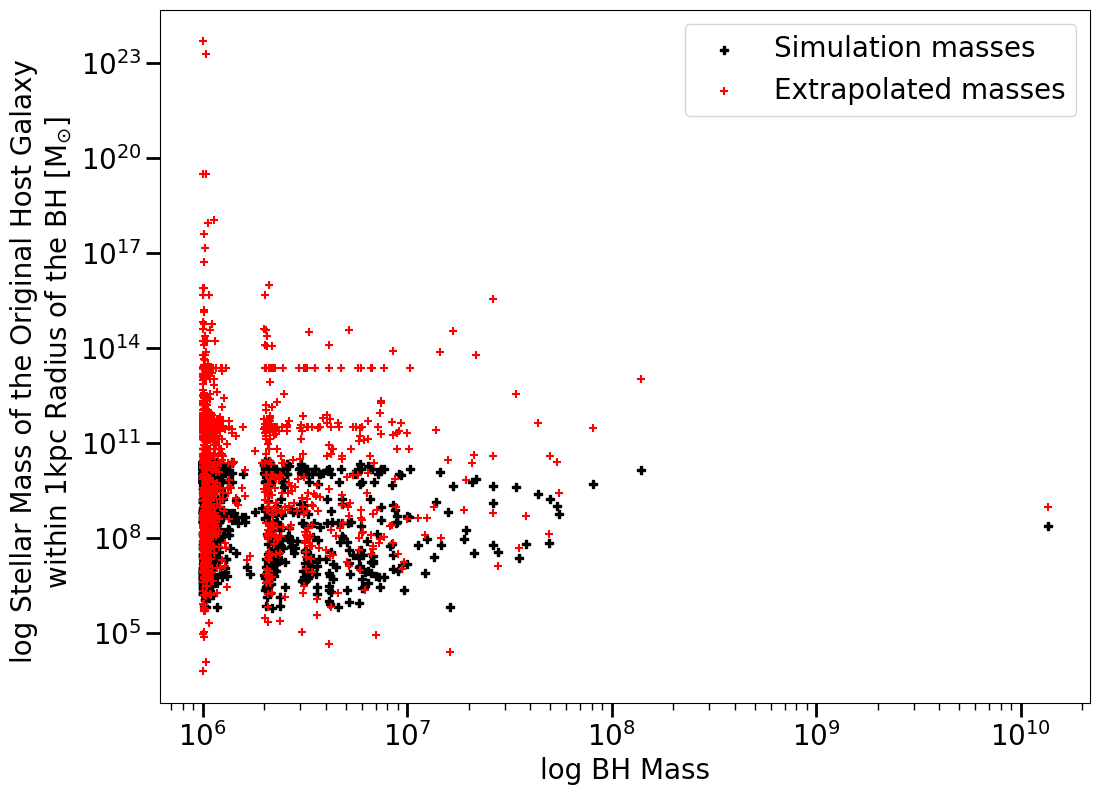

In [10]:
plt.scatter(my_masses['BH_mass'],my_masses['Sim_BH_host_mass'],c='k',marker='P',label='Simulation masses')
plt.scatter(my_masses['BH_mass'],my_masses['BH_host_mass'],c='r',marker='+',label='Extrapolated masses')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('log Stellar Mass of the Original Host Galaxy \n within 1kpc Radius of the BH [M$_{\odot}$]')
plt.xlabel('log BH Mass')
plt.legend(loc='upper right')

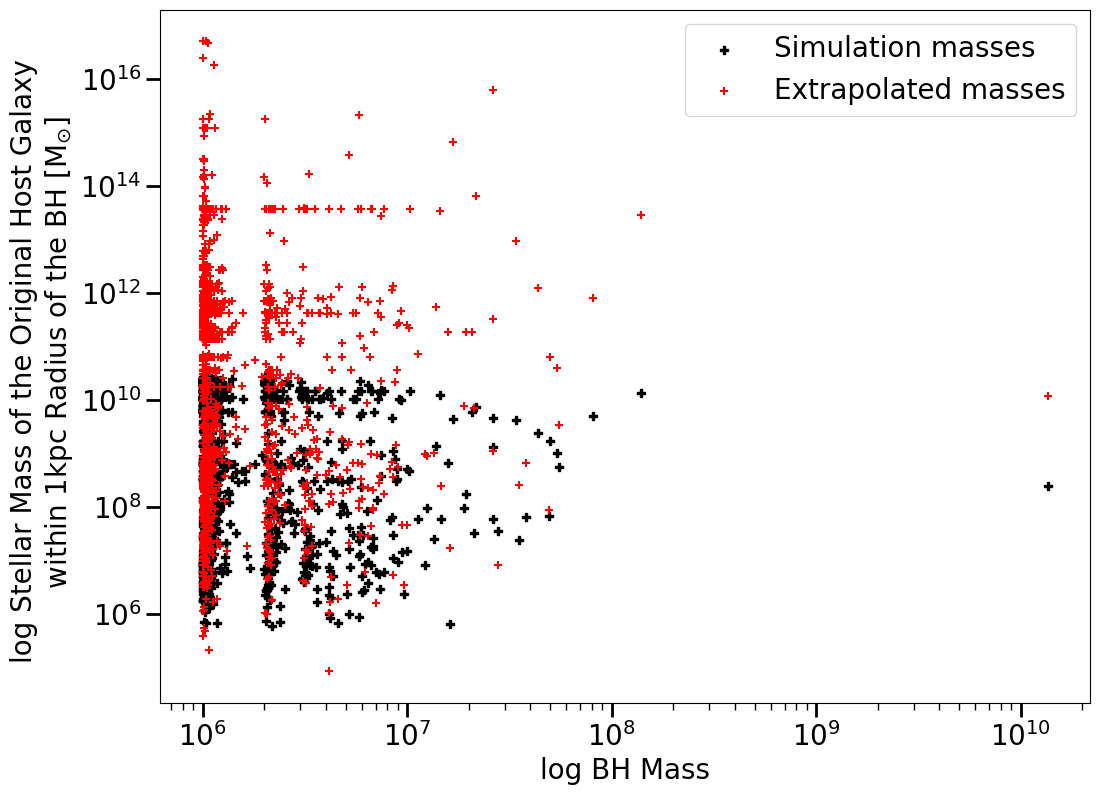

In [11]:
plt.scatter(my_masses2['BH_mass'],my_masses2['Sim_BH_host_mass'],c='k',marker='P',label='Simulation masses')
plt.scatter(my_masses2['BH_mass'],my_masses2['BH_host_mass'],c='r',marker='+',label='Extrapolated masses')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('log Stellar Mass of the Original Host Galaxy \n within 1kpc Radius of the BH [M$_{\odot}$]')
plt.xlabel('log BH Mass')
plt.legend(loc='upper right')


In [19]:
plt.scatter(my_saved_data['Cluster_centre_distance'],my_saved_data['BH_host_mass'],c=np.log10(my_saved_data['BH_mass']),cmap = 'rainbow')
plt.xlabel('Distance to the Centre of the Cluster [kpc]')
plt.ylabel('Stellar Mass of the Original Host Galaxy \n within 1kpc Radius of BH [M$_{\odot}$]')
plt.colorbar(label='Log BH Mass')
plt.yscale('log')


NameError: name 'my_saved_data' is not defined

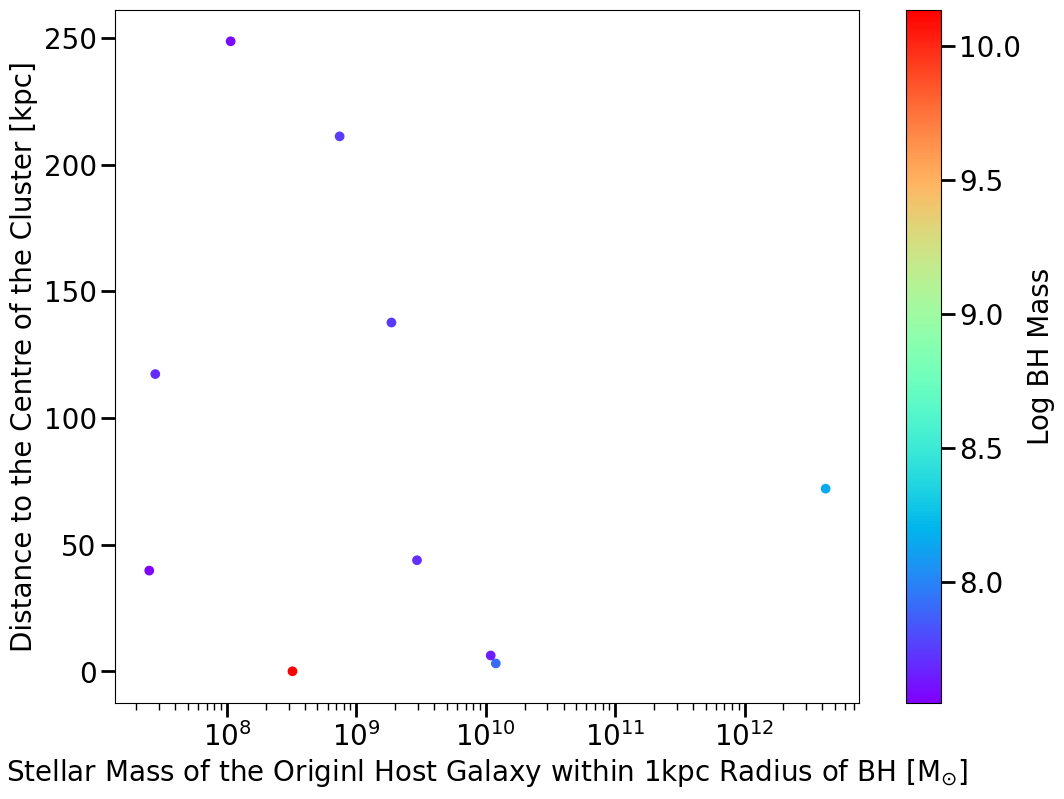

In [35]:
plt.scatter(my_saved_data['BH_host_mass'],my_saved_data['Cluster_centre_distance'],c=np.log10(my_saved_data['BH_mass']),cmap = 'rainbow')
plt.ylabel('Distance to the Centre of the Cluster [kpc]')
plt.xlabel('Stellar Mass of the Originl Host Galaxy within 1kpc Radius of BH [M$_{\odot}$]')
plt.colorbar(label='Log BH Mass')
plt.xscale('log')

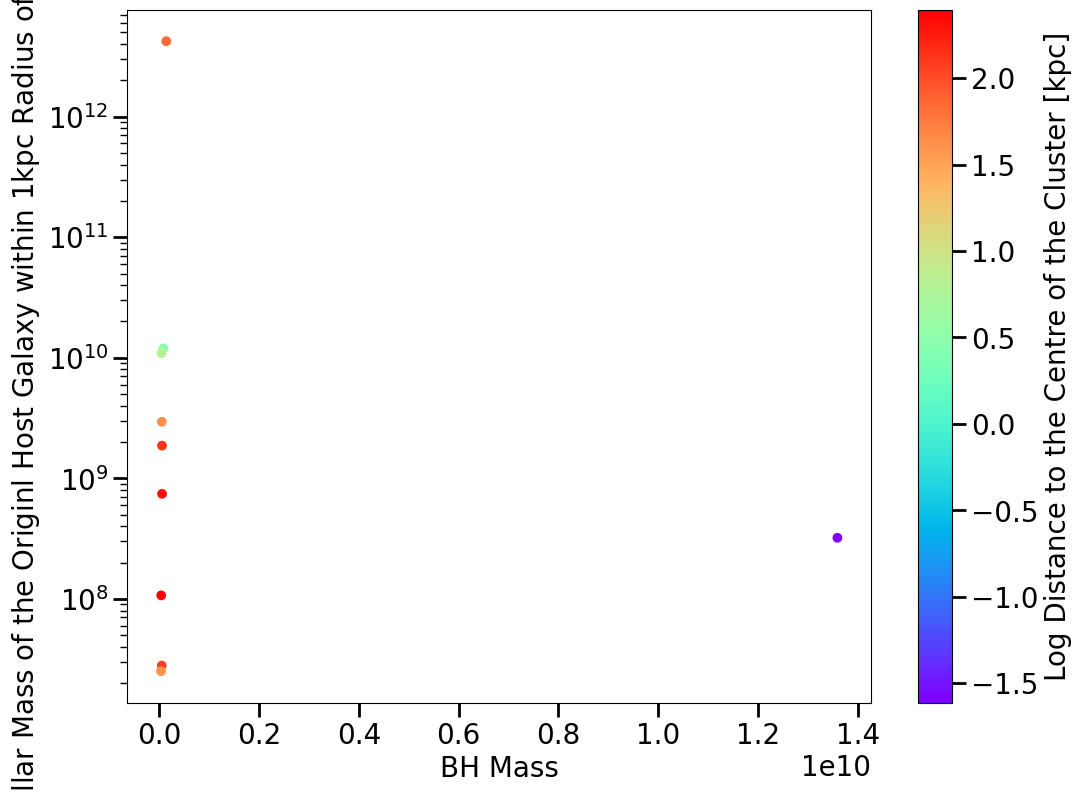

In [36]:
plt.scatter(my_saved_data['BH_mass'],my_saved_data['BH_host_mass'],c=np.log10(my_saved_data['Cluster_centre_distance']),cmap = 'rainbow')
plt.xlabel('BH Mass')
plt.ylabel('Stellar Mass of the Originl Host Galaxy within 1kpc Radius of BH [M$_{\odot}$]')
plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
plt.yscale('log')

In [6]:
#plt.plot(my_saved_data['Gamma'],my_saved_data['BH_mass'],)
f = open('Gamma_values.pkl','rb')
my_saved_data = pck.load(f)
f.close()

f = open('Gamma_values15.pkl','rb')
my_saved_data15 = pck.load(f)
f.close()


#plt.savefig("gamma_bhmass.png")


/tmp/ipykernel_120668/4293770125.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(my_saved_data15['Gamma'],my_saved_data15['BH_mass'],c=np.log(my_saved_data15['Cluster_centre_distance']),cmap = 'rainbow')
/tmp/ipykernel_120668/4293770125.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(my_saved_data15['Gamma'],my_saved_data15['BH_mass'],c=np.log(my_saved_data15['Cluster_centre_distance']),cmap = 'rainbow')


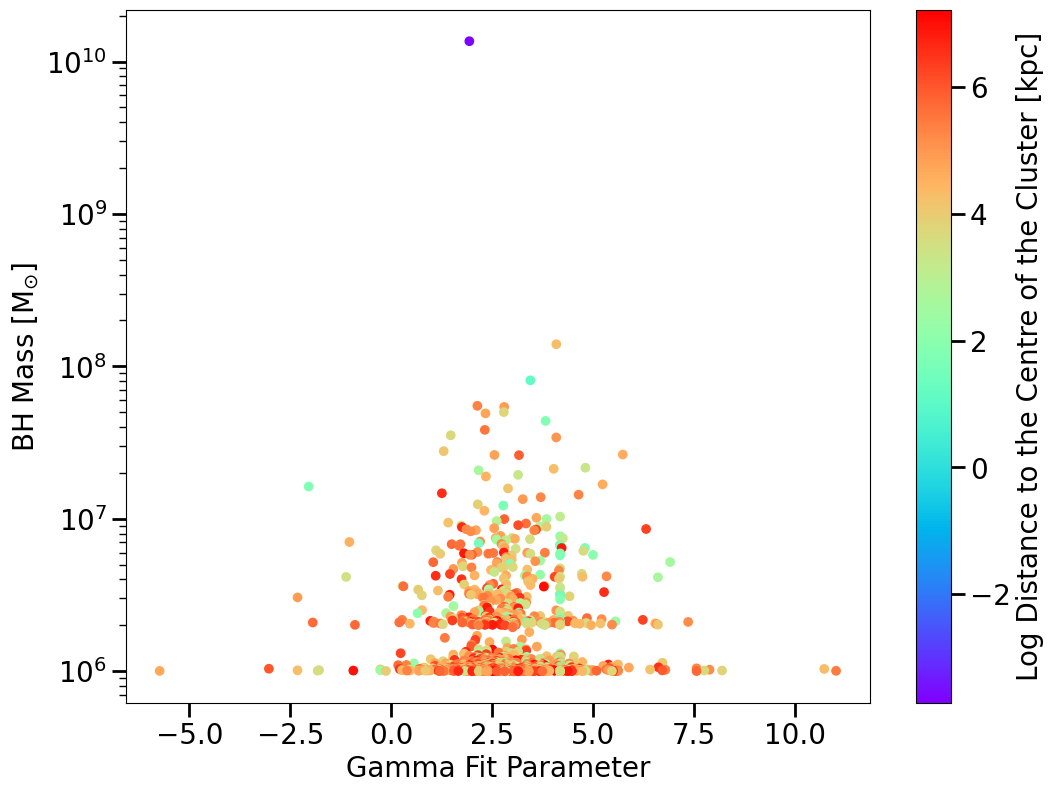

In [15]:
plt.scatter(my_saved_data15['Gamma'],my_saved_data15['BH_mass'],c=np.log(my_saved_data15['Cluster_centre_distance']),cmap = 'rainbow')
plt.ylabel('BH Mass [M$_{\odot}$]')
plt.xlabel('Gamma Fit Parameter')
plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
plt.yscale('log')

/tmp/ipykernel_153318/1121239401.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(my_saved_data['Gamma'],my_saved_data['BH_mass'],c=np.log10(my_saved_data['Cluster_centre_distance']),cmap = 'rainbow')
/tmp/ipykernel_153318/1121239401.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(my_saved_data['Gamma'],my_saved_data['BH_mass'],c=np.log10(my_saved_data['Cluster_centre_distance']),cmap = 'rainbow')


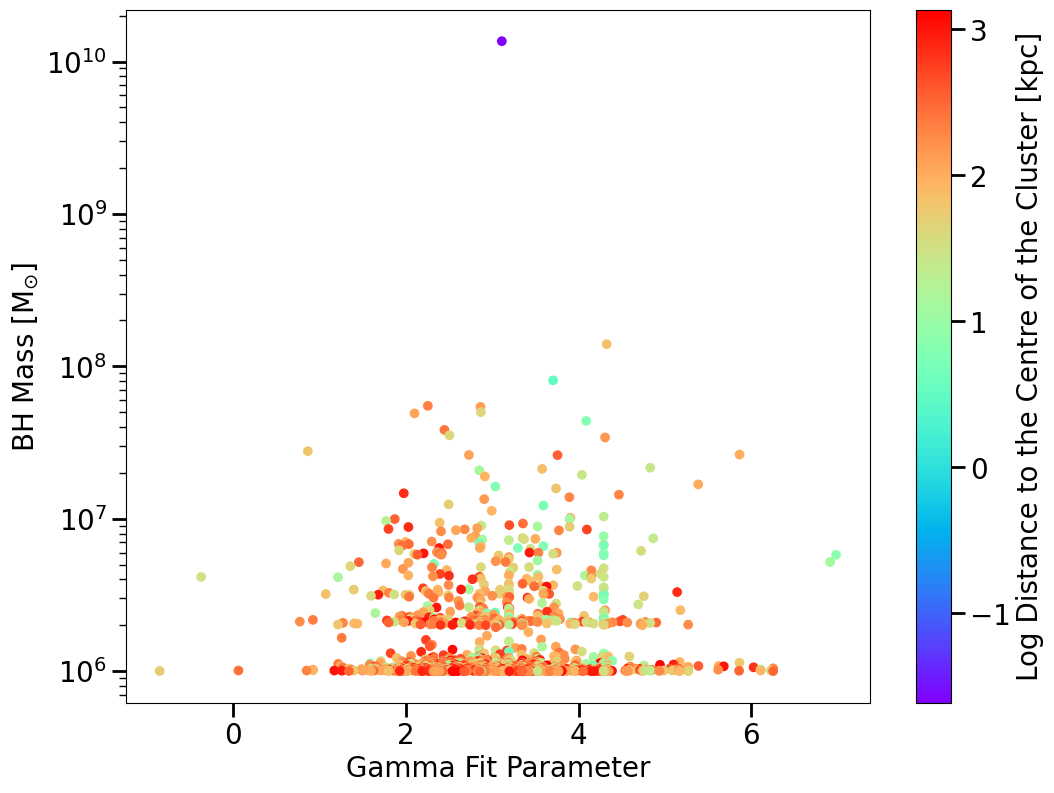

In [36]:
plt.scatter(my_saved_data['Gamma'],my_saved_data['BH_mass'],c=np.log10(my_saved_data['Cluster_centre_distance']),cmap = 'rainbow')
plt.ylabel('BH Mass [M$_{\odot}$]')
plt.xlabel('Gamma Fit Parameter')
plt.colorbar(label='Log Distance to the Centre of the Cluster [kpc]')
plt.yscale('log')

Text(0.5, 0, 'Gamma Fit Parameter')

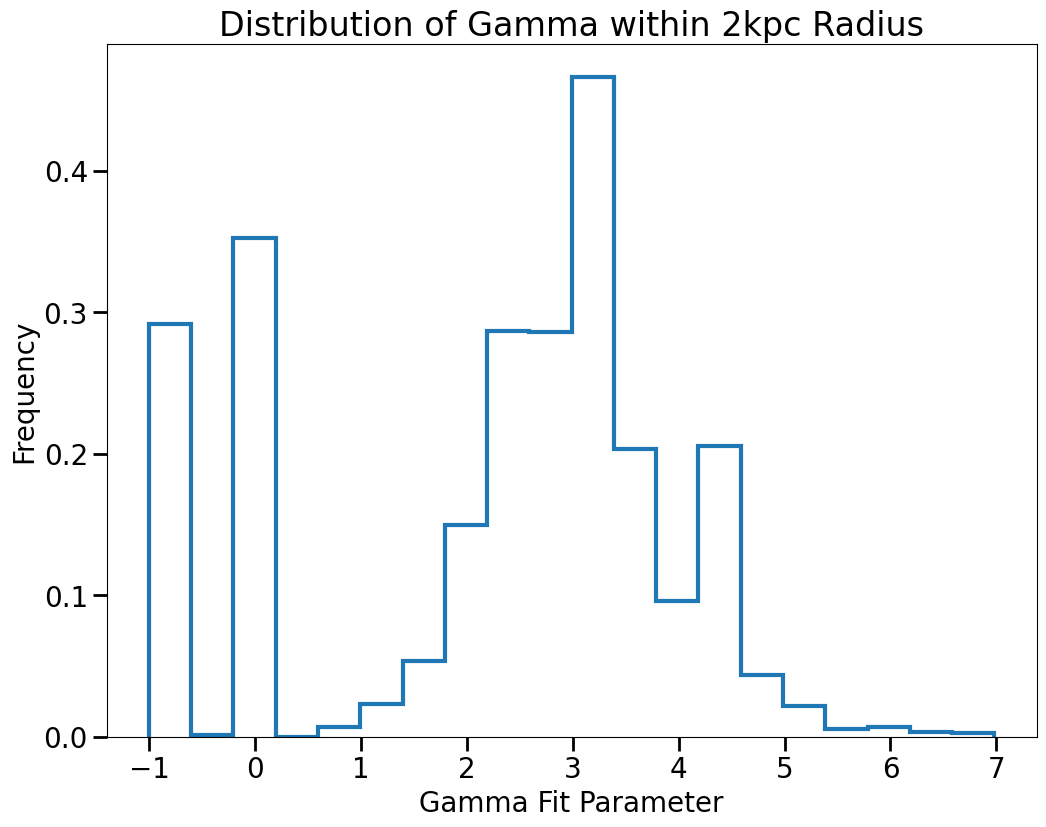

In [33]:
plt.hist(my_saved_data['Gamma'],histtype='step',lw=3,density=True,bins=20)
plt.title('Distribution of Gamma within 2kpc Radius')
plt.ylabel('Frequency')
plt.xlabel('Gamma Fit Parameter')


Zero density detected: 1429 

Never left halo1: 288 

Had no density profile: 254 

Didnt have enough density points: 5 

Had no density within the given radius: 14

Total bhs that werent extrapolated: 561/2193

Leaving: 1632...74%

Text(0.5, 0, 'Gamma Fit Parameter')

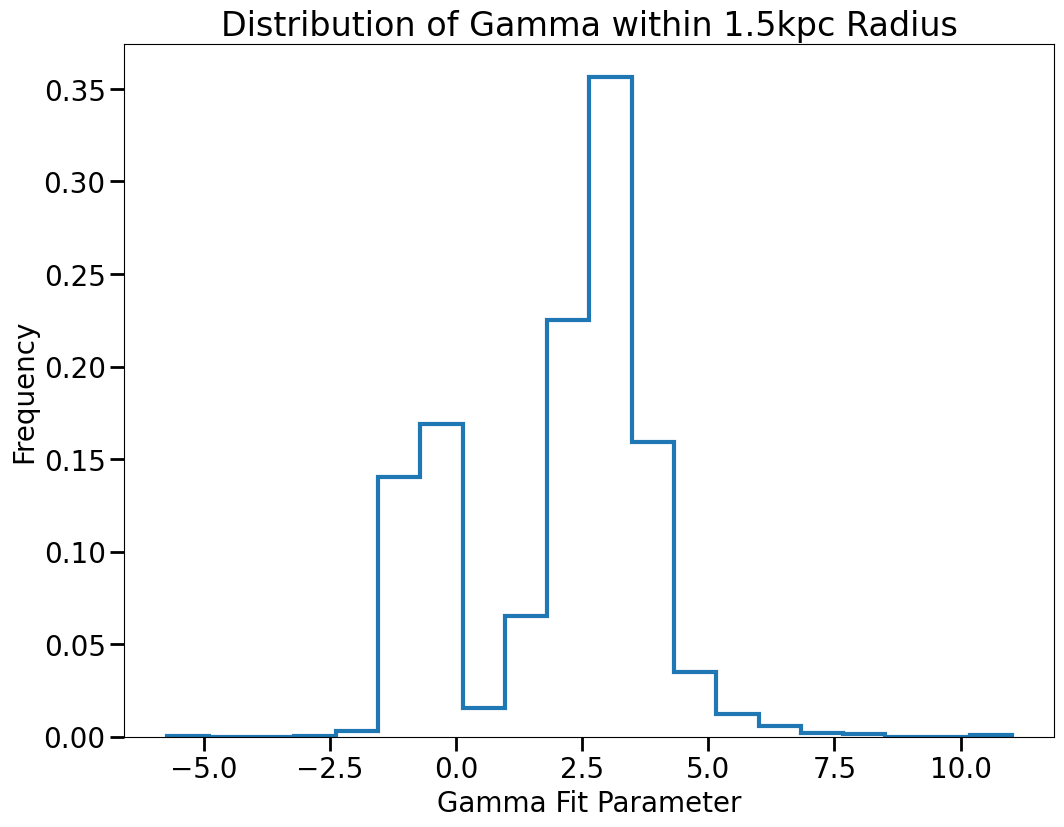

In [32]:

plt.hist(my_saved_data15['Gamma'],histtype='step',lw=3,density=True,bins=20)
plt.title('Distribution of Gamma within 1.5kpc Radius')
plt.ylabel('Frequency')
plt.xlabel('Gamma Fit Parameter')

In [88]:
halo_num = 1
bh_index = 18
R_density=1.5
R_min = 1
print('\n')
    
halo= db.get_halo('h1.cosmo50/%4096/'+str(halo_num))
bh = halo['BH_central'][bh_index]
mass = bh['BH_mass']


dist = bh['BH_central_distance']
bhid = bh.halo_number
    
print('BHid given:',bhid)
print('BH Mass:',mass)
    
old_shrink_h1,old_time_h1,old_max_radius = halo.calculate_for_progenitors('shrink_center','t()','max_radius')
old_hostid,old_host_path,old_time,old_center_dist = bh.calculate_for_progenitors('host_halo.halo_number()','host_halo.path()','t()','BH_central_distance')

bad_indices=[]

for i in range(len(old_time_h1)):
    if not old_time_h1[i] in old_time:
        bad_indices.append(i)
        
print(bad_indices)
#print(shrink_h1)
print(len(old_time_h1))
print(len(old_time))
print((old_time_h1))
print((old_time))
print(old_time_h1[bad_indices])

time_h1=np.delete(old_time_h1,bad_indices,axis=0)

bad_indices2=[] 

for i in range(len(old_time)):
    if not old_time[i] in old_time_h1:
        bad_indices2.append(i)
        
print(bad_indices2)
print(old_time[bad_indices2])

time=np.delete(old_time,bad_indices2,axis=0)

print(time)
print(time_h1)

if all(time)==all(time_h1):
    print('times are the same')
    
hostid = np.delete(old_hostid,bad_indices2,axis=0)
host_path=np.delete(old_host_path,bad_indices2,axis=0)
center_dist=np.delete(old_center_dist,bad_indices2,axis=0)

shrink_h1=np.delete(old_shrink_h1,bad_indices,axis=0)
max_radius = np.delete(old_max_radius,bad_indices,axis=0)

#for i in range(len(bad_indices)):
 #   old_shrink_h1.pop(bad_indices[i])

#print(old_shrink_h1)

dist_h1 = []

print(shrink_h1)

for i in range(len(time_h1)):
    dis = np.sqrt(((shrink_h1[i][0])**2)+((shrink_h1[i][1])**2)+((shrink_h1[i][2])**2))
    dist_h1.append(dis)

if all(i>1 for i in center_dist):
    print('ERROR: This BH was never central')
    print(0)
    
if all(i==halo_num for i in hostid):
    print('ERROR: This BH never left the input halo')
    print(0)
    
index = np.where((hostid!=halo_num))[0][0]

if center_dist[index]>1:
        
    for i in range(len(hostid)):
            
        if (hostid[i]!=halo_num) & (center_dist[i]<1):
            index = i
            break
        else:
            pass
        
print(max_radius[index])   

original_halo = db.get_halo(host_path[index])
shrink = original_halo['shrink_center']

print(shrink)

dist = np.sqrt(((shrink[0])**2)+((shrink[1])**2)+((shrink[2])**2))
shrink2 = shrink_h1[index]

print(shrink2)

dist2 = dist_h1[index]

print(dist2)

difference = np.abs(dist2-dist)

if difference < max_radius[index]:
    
    print('First original inside h1')
    
    inside=0
    outside:bool = False
    
    while outside==False:
        
        print(outside)
        index+=1
        if index>=len(hostid):
            print('WRONG')
        if (hostid[index]!=halo_num) & (center_dist[index]<1):
                
            original_halo = db.get_halo(host_path[index])
            
            print(original_halo)
            
            shrink = original_halo['shrink_center']
            
            print(shrink)
            
            dist = np.sqrt(((shrink[0])**2)+((shrink[1])**2)+((shrink[2])**2))
            
            print(dist)
            
            dist2=dist_h1[index]
            
            print(dist2)
            
            diff = abs(dist2-dist)
            
            print(diff)
            
            if diff>=max_radius[index]:
                print('yes')
                print(index)
                if time_h1[index]==time[index]:
                    print('yes2')
                    
                    if original_halo['Mstar']>10000000:
                        outside = True
                        print('complete')
                    else:
                        print('Original Galaxy is not resolvable')
        
else:   
    inside = 1
step = original_halo.timestep

#if 'star_density_profile' in original_halo:
 #   print('Original BH Host:',original_halo.halo_number)
  #  print('Time in simulation:',time[index],'Gyr') 
#else:
 #   print('ERROR: The original host has no density profile')
  #  print(0) 
                                                          
    #steps = np.arange(0,R_density,timestep)
    
rbins = np.arange(len(original_halo['star_density_profile']))*0.1+0.5
start_cut_off = (R_min*10)-5
end_cut_off=(R_density*10)-4
rounded = round(R_density,1)
if rounded!=R_density:
    end_cut_off+=1
density = original_halo['star_density_profile']
ok = np.where(density>0) 
#print(density)
#print(rbins)
if len(density[ok])==0:
    print('ERROR: Star density within '+str(R_density)+'kpc is zero')
    print(0)
    
check = np.array_equal(density,density[ok])
    
zero_areas = 0
    
if check==False:
    print('ERROR: Zero density values detected - erased from plot')
    zero_areas = 1
    
plotbins = rbins[ok][0:int(end_cut_off)]
plot_density = density[ok][0:int(end_cut_off)]
#print(plotbins)
#print(plot_density)
 
steps = rbins[ok][int(start_cut_off):int(end_cut_off)]
#print(steps)

if len(steps) == 0:
    print('ERROR: Not enough density points to evaluate')
    
y = np.log(plot_density[int(start_cut_off):int(end_cut_off)])
x = np.log(steps)
#print(y)
constants = np.polyfit(x,y,1)
a = np.exp(constants[1])
b = -constants[0]

#print('Parameters:',a,b) 

steps2 = np.arange(0,R_min,0.1)
new_steps = np.append(steps2,steps)

plotbins2 = np.arange(0,0.5,0.1)
new_plotbins = np.append(plotbins2,plotbins)

def function(x):
    y = []
    y = a*x**(-b)
    return y

y = function(new_plotbins)


plt.plot(plotbins,plot_density,ls='-',c='deeppink',lw=4)
plt.yscale('log')
plt.ylabel(r'Star Density [M$_{\odot}$/kpc$^3$]')
plt.xlabel(r'R [kpc]')
plt.title('Star Density of Host at 0-'+str(R_density)+'kpc')
plt.axvline(x=center_dist[index], label='BH Location',c='lime',lw=2,ls='--')
plt.axvline(x=1,label='Resolution Limit',c='greenyellow',lw=2,ls='--')
plt.legend(loc='upper right')
        
plt.plot(new_plotbins,y,c='pink',ls='-.',label='Extrapolated Star Desnity',lw=3)
plt.yscale('log')
plt.legend(loc='upper right')
    
print(a,b)



BHid given: 568964566
BH Mass: 20797029.05386
[]
69
72
[13.8007975  13.58534257 13.26216017 13.25879369 13.10730194 12.93897778
 12.72352285 12.61579539 12.45757067 12.29261299 12.20171794 12.1512207
 11.9694306  11.69001249 11.64624821 11.32306581 11.18840648 10.99988342
 10.76759607 10.70363289 10.67670102 10.35351863 10.22895875 10.03033624
  9.76775054  9.70715384  9.38397145  9.32000827  9.06078905  8.88573192
  8.73760666  8.6096803   8.468288    8.41442427  8.09124187  8.06094352
  7.76805948  7.67043146  7.44487708  7.29675182  7.12169469  7.03753261
  6.93317163  6.7985123   6.15214751  5.86936291  5.82896511  5.50578272
  5.18260033  4.85941793  4.53623554  4.21305314  3.88987075  3.56668836
  3.29063673  3.24350596  2.92032357  2.59714118  2.27395878  2.15276538
  1.95077639  1.62759399  1.54679839  1.3044116   1.17648524  0.98122921
  0.93409844  0.76577428  0.65804681]
[13.8007975  13.58534257 13.26216017 13.25879369 13.10730194 12.93897778
 12.72352285 12.61579539 12.45

IndexError: index 69 is out of bounds for axis 0 with size 69

In [64]:
def long_host_density(halo_num,bh_index,R_density=2):
    
    '''The bh given has to be in the host given at the last timestep, the default R_desnity = 2, timestep = 0.1'''
    
    print('\n')
    
    halo= db.get_halo('h1.cosmo50/%4096/'+str(halo_num))
    bh = halo['BH_central'][bh_index]
    mass = 1
    dist = 1
    bhid = bh.halo_number
    a=1
    b=1
    hostid,host_path,time,center_dist = bh.calculate_for_progenitors('host_halo.halo_number()','host_halo.path()','t()','BH_central_distance')
    
    if all(i>1 for i in center_dist):
        print('ERROR: This BH was never central')
        return -1,0,0,0,bhid,0,0
    
    if all(i==halo_num for i in hostid):
        print('ERROR: This BH never left the input halo')
        return 0,-1,0,0,bhid,0,0
    
    index = np.where(hostid!=halo_num)[0][0]

    if center_dist[index]>1:
        
        for i in range(len(hostid)):
            
            if (hostid[i]!=halo_num) & (center_dist[i]<1):
                index = i
                break
            else:
                pass
    
    original_halo = db.get_halo(host_path[index])
    step = original_halo.timestep
    
    if 'star_density_profile' in original_halo:
        print('Original BH Host:',original_halo.halo_number)
        print('Step:',step)
    else:
        print('ERROR: The original host has no density profile')
        return  0,0,-1,0,bhid,0,0
    

    original_mass = 1
    
    rbins = np.arange(len(original_halo['star_density_profile']))*0.1+0.5
    cut_off = 10
    density = original_halo['star_density_profile']
    ok = np.where(density>0) 
    
    if len(density[ok])==0:
        print('ERROR: Star density within '+str(R_density)+'kpc is zero')
        return 0,0,0,-1,bhid,0,0
    
    zero_areas = 0
        
    plotbins = rbins[ok][0:int(R_density*cut_off)]
    plot_density = density[ok][0:int(R_density*cut_off)]

    steps = rbins[ok][cut_off:int(R_density*cut_off)]
    
    if len(steps) == 0:
        print('ERROR: Not enough density points to evaluate')
        return 0,0,0,0,bhid,-1,0
    
    return a,b,mass,dist,bhid,zero_areas,original_mass

In [66]:
#b = []
#Cluster_distance=[]
BHid=[]
error_bhid=[]
#BH_mass=[]

density_change = 0
never_left = 0
no_profile=0
not_enough_points=0
no_density_at_rad=0
never_central=0

for i in range(2193):
    
    a,B,x,y,z,t,c = long_host_density(1,i)
      
    if a == -1:
        never_central+=1
        pass
    
    if B == -1:
        never_left+=1
        pass
    
    if x == -1:
        no_profile+=1
        pass
    
    if y == -1:
        no_density_at_rad+=1
        pass
    
    if t == -1:
        not_enough_points+=1
        pass
        
    if c ==0:
        error_bhid.append(z)
        pass
    
    print('Irreration num:',i)

print('\nNever central',never_central,'\nNever left halo1:',never_left,'\nHad no density profile:',no_profile,'\nDidnt have enough density points:',not_enough_points,'\nHad no density within the given radius:',no_density_at_rad)


other_file={'Error_bhids':error_bhid}
z = open('Faulty_BHs_ids.pkl','wb')
pck.dump(other_file,z)
z.close()



Original BH Host: 3
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000288' z=5.77 t=0.98 Gyr>
Irreration num: 0


Original BH Host: 32
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.001824' z=0.93 t=6.15 Gyr>
Irreration num: 1


Original BH Host: 76
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000864' z=2.25 t=2.92 Gyr>
Irreration num: 2


Original BH Host: 10
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000480' z=3.83 t=1.63 Gyr>
Irreration num: 3


Original BH Host: 51
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000636' z=3.00 t=2.15 Gyr>
Irreration num: 4


Original BH Host: 36
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000672' z=2.85 t=2.27 Gyr>
Irreration num: 5


Original BH Host: 1570
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.002554' z=0.50 t=8.61 Gyr>
Irreration num: 6


Original BH Host: 157
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000636' z=3.00 t=2.15 Gyr>
Irreration num: 

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_ypgt, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 81


Original BH Host: 207
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000224' z=6.99 t=0.77 Gyr>
Irreration num: 82


ERROR: This BH was never central
Irreration num: 83


Original BH Host: 3904
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000974' z=2.00 t=3.29 Gyr>
Irreration num: 84


Original BH Host: 883
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.003264' z=0.23 t=11.00 Gyr>
Irreration num: 85


Original BH Host: 2806
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000456' z=3.99 t=1.55 Gyr>
Irreration num: 86


ERROR: The original host has no density profile
Irreration num: 87


Original BH Host: 13
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000138' z=9.97 t=0.48 Gyr>
Irreration num: 88


Original BH Host: 873
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.003195' z=0.25 t=10.77 Gyr>
Irreration num: 89


Original BH Host: 93
Step: <TimeStep 'h1.cosmo50/h1.cosmo5

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_thte, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 168


ERROR: The original host has no density profile
Irreration num: 169


Original BH Host: 2333
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000274' z=6.00 t=0.93 Gyr>
Irreration num: 170


Original BH Host: 326
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000456' z=3.99 t=1.55 Gyr>
Irreration num: 171


Original BH Host: 157
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000224' z=6.99 t=0.77 Gyr>
Irreration num: 172


Original BH Host: 545
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000096' z=12.88 t=0.33 Gyr>
ERROR: Not enough density points to evaluate
Irreration num: 173


Original BH Host: 696
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000346' z=5.00 t=1.18 Gyr>
Irreration num: 174


ERROR: This BH was never central
Irreration num: 175


ERROR: The original host has no density profile
Irreration num: 176


ERROR: This BH was never central
Irreration num: 177


ERROR: T

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_tquf, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: The original host has no density profile
Irreration num: 357


Original BH Host: 772
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000224' z=6.99 t=0.77 Gyr>
Irreration num: 358


ERROR: This BH was never central
Irreration num: 359


ERROR: This BH was never central
Irreration num: 360


ERROR: The original host has no density profile
Irreration num: 361


ERROR: The original host has no density profile
Irreration num: 362


ERROR: This BH was never central
Irreration num: 363


ERROR: This BH was never central
Irreration num: 364


ERROR: The original host has no density profile
Irreration num: 365


ERROR: The original host has no density profile
Irreration num: 366


ERROR: This BH was never central
Irreration num: 367


Original BH Host: 1276
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000672' z=2.85 t=2.27 Gyr>
Irreration num: 368


ERROR: This BH was never central
Irreration num: 369


Original BH Host: 813
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_cpoc, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 423


ERROR: The original host has no density profile
Irreration num: 424


ERROR: This BH was never central
Irreration num: 425


ERROR: The original host has no density profile
Irreration num: 426


ERROR: The original host has no density profile
Irreration num: 427


ERROR: This BH was never central
Irreration num: 428


ERROR: This BH was never central
Irreration num: 429


ERROR: This BH was never central
Irreration num: 430


Original BH Host: 2223
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000346' z=5.00 t=1.18 Gyr>
Irreration num: 431


ERROR: The original host has no density profile
Irreration num: 432


ERROR: The original host has no density profile
Irreration num: 433


ERROR: The original host has no density profile
Irreration num: 434


ERROR: This BH was never central
Irreration num: 435


Original BH Host: 218
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000974' z=2.00 t=3.29 Gyr>
Irreration num:

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_imqv, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


Original BH Host: 862
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000224' z=6.99 t=0.77 Gyr>
Irreration num: 466


ERROR: This BH was never central
Irreration num: 467


ERROR: The original host has no density profile
Irreration num: 468


ERROR: The original host has no density profile
Irreration num: 469


ERROR: The original host has no density profile
Irreration num: 470


ERROR: This BH was never central
Irreration num: 471


ERROR: The original host has no density profile
Irreration num: 472


ERROR: This BH was never central
Irreration num: 473


ERROR: This BH was never central
Irreration num: 474


ERROR: This BH was never central
Irreration num: 475


ERROR: This BH was never central
Irreration num: 476


ERROR: This BH was never central
Irreration num: 477


ERROR: The original host has no density profile
Irreration num: 478


ERROR: This BH was never central
Irreration num: 479


ERROR: This BH was never central
Irreration num: 480


ERROR: The original host ha

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_wotk, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 927


ERROR: This BH was never central
Irreration num: 928


ERROR: The original host has no density profile
Irreration num: 929


ERROR: The original host has no density profile
Irreration num: 930


Original BH Host: 369
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000864' z=2.25 t=2.92 Gyr>
Irreration num: 931


ERROR: This BH was never central
Irreration num: 932


ERROR: The original host has no density profile
Irreration num: 933


ERROR: The original host has no density profile
Irreration num: 934


ERROR: The original host has no density profile
Irreration num: 935


ERROR: This BH was never central
Irreration num: 936


Original BH Host: 259
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000384' z=4.60 t=1.30 Gyr>
Irreration num: 937


ERROR: The original host has no density profile
Irreration num: 938


ERROR: This BH was never central
Irreration num: 939


ERROR: This BH was never central
Irreration num: 

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_prgp, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 1011


ERROR: This BH was never central
Irreration num: 1012


ERROR: This BH was never central
Irreration num: 1013


ERROR: This BH was never central
Irreration num: 1014


ERROR: The original host has no density profile
Irreration num: 1015


Original BH Host: 164
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000864' z=2.25 t=2.92 Gyr>
Irreration num: 1016


ERROR: This BH was never central
Irreration num: 1017


ERROR: This BH was never central
Irreration num: 1018


Original BH Host: 11
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000974' z=2.00 t=3.29 Gyr>
Irreration num: 1019


ERROR: The original host has no density profile
Irreration num: 1020


ERROR: This BH was never central
Irreration num: 1021


ERROR: This BH was never central
Irreration num: 1022


ERROR: This BH was never central
Irreration num: 1023


Original BH Host: 16
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000274' z=6.00 t=0.

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_pcwk, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: The original host has no density profile
Irreration num: 1030


ERROR: This BH was never central
Irreration num: 1031


ERROR: The original host has no density profile
Irreration num: 1032


ERROR: This BH was never central
Irreration num: 1033


ERROR: This BH was never central
Irreration num: 1034


ERROR: This BH was never central
Irreration num: 1035


ERROR: This BH was never central
Irreration num: 1036


ERROR: The original host has no density profile
Irreration num: 1037


Original BH Host: 38
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000288' z=5.77 t=0.98 Gyr>
Irreration num: 1038


ERROR: This BH was never central
Irreration num: 1039


ERROR: This BH was never central
Irreration num: 1040


Original BH Host: 248
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000384' z=4.60 t=1.30 Gyr>
Irreration num: 1041


ERROR: This BH was never central
Irreration num: 1042


ERROR: This BH was never central
Irreration num: 1043


ERROR: This BH was never c

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_xjty, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: The original host has no density profile
Irreration num: 1114


ERROR: This BH was never central
Irreration num: 1115


ERROR: This BH was never central
Irreration num: 1116


ERROR: This BH was never central
Irreration num: 1117


ERROR: This BH was never central
Irreration num: 1118


ERROR: This BH was never central
Irreration num: 1119


Original BH Host: 641
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000224' z=6.99 t=0.77 Gyr>
Irreration num: 1120


ERROR: This BH was never central
Irreration num: 1121


ERROR: This BH was never central
Irreration num: 1122


Original BH Host: 214
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000384' z=4.60 t=1.30 Gyr>
Irreration num: 1123


Original BH Host: 3607
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.001056' z=1.84 t=3.57 Gyr>
Irreration num: 1124


ERROR: This BH was never central
Irreration num: 1125


ERROR: The original host has no density profile
Irreration num: 1126


Original BH Host: 761


/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_vpou, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 1231


ERROR: This BH was never central
Irreration num: 1232


ERROR: The original host has no density profile
Irreration num: 1233


ERROR: This BH was never central
Irreration num: 1234


ERROR: The original host has no density profile
Irreration num: 1235


ERROR: This BH was never central
Irreration num: 1236


ERROR: The original host has no density profile
Irreration num: 1237


ERROR: This BH was never central
Irreration num: 1238


Original BH Host: 125
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000288' z=5.77 t=0.98 Gyr>
Irreration num: 1239


ERROR: This BH was never central
Irreration num: 1240


ERROR: The original host has no density profile
Irreration num: 1241


ERROR: This BH was never central
Irreration num: 1242


ERROR: This BH was never central
Irreration num: 1243


Original BH Host: 260
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000480' z=3.83 t=1.63 Gyr>
Irreration num: 1244


ERROR: The

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_nckh, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 1431


ERROR: This BH was never central
Irreration num: 1432


Original BH Host: 906
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000224' z=6.99 t=0.77 Gyr>
Irreration num: 1433


ERROR: The original host has no density profile
Irreration num: 1434


ERROR: This BH was never central
Irreration num: 1435


Original BH Host: 61
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000274' z=6.00 t=0.93 Gyr>
Irreration num: 1436


ERROR: The original host has no density profile
Irreration num: 1437




/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_jyyz, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 1438


ERROR: The original host has no density profile
Irreration num: 1439


ERROR: This BH was never central
Irreration num: 1440


ERROR: This BH was never central
Irreration num: 1441


ERROR: This BH was never central
Irreration num: 1442


ERROR: This BH was never central
Irreration num: 1443


ERROR: This BH was never central
Irreration num: 1444


Original BH Host: 552
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000672' z=2.85 t=2.27 Gyr>
Irreration num: 1445


ERROR: This BH was never central
Irreration num: 1446


ERROR: The original host has no density profile
Irreration num: 1447


ERROR: This BH was never central
Irreration num: 1448


ERROR: This BH was never central
Irreration num: 1449


Original BH Host: 1831
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.003264' z=0.23 t=11.00 Gyr>
Irreration num: 1450


Original BH Host: 993
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000274' z=6.00 

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_bxaq, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 1492


Original BH Host: 118
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000187' z=8.00 t=0.64 Gyr>
Irreration num: 1493


ERROR: This BH was never central
Irreration num: 1494


ERROR: This BH was never central
Irreration num: 1495


Original BH Host: 365
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000456' z=3.99 t=1.55 Gyr>
Irreration num: 1496


ERROR: This BH was never central
Irreration num: 1497


ERROR: This BH was never central
Irreration num: 1498


ERROR: The original host has no density profile
Irreration num: 1499


ERROR: This BH was never central
Irreration num: 1500


ERROR: The original host has no density profile
Irreration num: 1501


ERROR: This BH was never central
Irreration num: 1502


ERROR: This BH was never central
Irreration num: 1503


ERROR: This BH was never central
Irreration num: 1504


ERROR: This BH was never central
Irreration num: 1505


ERROR: The original host has no density 

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_pgkt, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


Original BH Host: 1418
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000288' z=5.77 t=0.98 Gyr>
Irreration num: 1641


ERROR: This BH was never central
Irreration num: 1642


ERROR: This BH was never central
Irreration num: 1643


ERROR: This BH was never central
Irreration num: 1644


ERROR: This BH was never central
Irreration num: 1645


ERROR: This BH was never central
Irreration num: 1646


ERROR: This BH was never central
Irreration num: 1647


Original BH Host: 550
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000672' z=2.85 t=2.27 Gyr>
Irreration num: 1648


ERROR: This BH was never central
Irreration num: 1649


Original BH Host: 36
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000456' z=3.99 t=1.55 Gyr>
Irreration num: 1650


ERROR: The original host has no density profile
Irreration num: 1651


ERROR: This BH was never central
Irreration num: 1652


ERROR: This BH was never central
Irreration num: 1653


ERROR: This BH was never central
Irrer

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_kzkp, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


Original BH Host: 711
Step: <TimeStep 'h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.000288' z=5.77 t=0.98 Gyr>
Irreration num: 1918


ERROR: This BH was never central
Irreration num: 1919


ERROR: This BH was never central
Irreration num: 1920


ERROR: This BH was never central
Irreration num: 1921


ERROR: This BH was never central
Irreration num: 1922


ERROR: This BH was never central
Irreration num: 1923


ERROR: This BH was never central
Irreration num: 1924


ERROR: The original host has no density profile
Irreration num: 1925


ERROR: This BH was never central
Irreration num: 1926


ERROR: The original host has no density profile
Irreration num: 1927


ERROR: This BH was never central
Irreration num: 1928


ERROR: This BH was never central
Irreration num: 1929


ERROR: This BH was never central
Irreration num: 1930


ERROR: This BH was never central
Irreration num: 1931


ERROR: This BH was never central
Irreration num: 1932


ERROR: This BH was never central
Irreration num: 1933


E

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_nfem, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: The original host has no density profile
Irreration num: 2015


ERROR: The original host has no density profile
Irreration num: 2016


ERROR: The original host has no density profile
Irreration num: 2017


ERROR: This BH was never central
Irreration num: 2018


ERROR: This BH was never central
Irreration num: 2019


ERROR: This BH was never central
Irreration num: 2020


ERROR: This BH was never central
Irreration num: 2021


ERROR: This BH was never central
Irreration num: 2022


ERROR: This BH was never central
Irreration num: 2023


ERROR: This BH was never central
Irreration num: 2024




/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_exux, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 2025


ERROR: This BH was never central
Irreration num: 2026


ERROR: This BH was never central
Irreration num: 2027


ERROR: This BH was never central
Irreration num: 2028


ERROR: This BH was never central
Irreration num: 2029


ERROR: This BH was never central
Irreration num: 2030


ERROR: This BH was never central
Irreration num: 2031


ERROR: This BH was never central
Irreration num: 2032


ERROR: This BH was never central
Irreration num: 2033


ERROR: This BH was never central
Irreration num: 2034


ERROR: This BH was never central
Irreration num: 2035


ERROR: This BH was never central
Irreration num: 2036


ERROR: This BH was never central
Irreration num: 2037


ERROR: This BH was never central
Irreration num: 2038


ERROR: This BH was never central
Irreration num: 2039


ERROR: This BH was never central
Irreration num: 2040


ERROR: This BH was never central
Irreration num: 2041


ERROR: This BH was never central
Irreration num:

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_gjgy, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
Irreration num: 2060


ERROR: This BH was never central
Irreration num: 2061


ERROR: This BH was never central
Irreration num: 2062


ERROR: This BH was never central
Irreration num: 2063


ERROR: This BH was never central
Irreration num: 2064


ERROR: This BH was never central
Irreration num: 2065


ERROR: This BH was never central
Irreration num: 2066


ERROR: This BH was never central
Irreration num: 2067


ERROR: This BH was never central
Irreration num: 2068


ERROR: This BH was never central
Irreration num: 2069


ERROR: This BH was never central
Irreration num: 2070


ERROR: This BH was never central
Irreration num: 2071


ERROR: This BH was never central
Irreration num: 2072


ERROR: This BH was never central
Irreration num: 2073


ERROR: This BH was never central
Irreration num: 2074


ERROR: This BH was never central
Irreration num: 2075


ERROR: This BH was never central
Irreration num: 2076


ERROR: This BH was never central
Irreration num:

Never central: 1378 
Never left halo1: 13 
Had no density profile: 254 
Didnt have enough density points: 5 
Had no density within the given radius: 10


In [9]:
def normalise(a,b,radius=0.35):
    def function(x):
        y = []
        y = a*x**(-b)
        return y
    density = function(radius)
    C = density*(radius**2)
    return C

In [6]:
def tidal_history(a,b,bhid,BH_index,step,original_halo):
    
    C = normalise(a,b)
    short_step = int(step.path.split('.')[-1])
    original_halo_num = int(original_halo.path.split('_')[-1])
    short_step = str(short_step)
    if len(short_step)!=4:
        short_step = str(0)+str(short_step)
        if len(short_step)!=3:
            short_step = str(0)+str(short_step)
        
    halo= db.get_halo('h1.cosmo50/%'+str(short_step)+'/'+str(halo_num))
    host= db.get_halo('h1.cosmo50/%'+str(short_step)+'/'+str(original_halo_num))
    bh = db.get_halo('h1.cosmo50/%'+str(short_step)+'/BH_'+str(bhid))

    mass_hist,radius_hist = halo.calculate_for_descendants('at(radius(200),star_mass_profile)','max_radius')
    host_num_hist,dist,time,bh_mass= bh.calculate_for_descendants('host_halo.halo_number()','BH_central_distance','t()','BH_mass')
    host_mass = host.calculate('at(1.4,star_mass_profile)')

    for i in range(len(mass_hist)):
        if (host_num_hist[i] == 1 & host_num_hist[i+1] == 1):
            index = i
            break 

    dist = dist[index:]
    mass_hist = mass_hist[index:]
    radius_hist = radius_hist[index:]
    time = time[index:]
    host_num_hist = host_num_hist[index:]
    bh_mass = bh_mass[index:]
    infall = time[0]
    
    # if all(i==halo_num for i in host_num_hist):
    #     print('Correct ')
    # else: 
    #     print('Error')
    #     return 0,0,0
    
    rj=[]
    m=[]
        
    for i in range(len(mass_hist)):
        if i == 0:
            
            M = mass_hist[i]
            R = dist[i]
            rj.append(1.4)
            m.append(C*4*np.pi*rj[i])            
            
        else: 
           
            if rj[i]<=(min(rj)):
                m.append(C*4*np.pi*rj[i])
                
            else:
                
                m.append(m[i-1])
                
        M = mass_hist[i]
        R = dist[i]    
        rj.append((((m[i]/M)/(3+m[i]/M))**(1/3))*R)
        
       
    return(rj,time,m,bh_mass,infall)

In [19]:
f = open('Extrapolation_Outputs.pkl','rb')
data = pck.load(f)
f.close()
ids=data['bhid']
index=data['index']
a=data['a']
b=data['b']
step=data['step']
host=data['host']
print(str(step))
rj=[]
time=[]
mass=[]
infall=[]

for i in range(len(index)):
    rj,time,mass,infall = tidal_history(a[i],b[i],ids[i],index[i],step[i],host[i])
    rj.append(rj)
    time.append(time)
    mass.append(mass)
    infall.append(infall)

data_to_file={'rj':rj,'time':time,'mass':mass,'infall':infall}
f = open('Disruption_Outputs.pkl','wb')
pck.dump(data_to_file,f)
f.close()

AttributeError: 'NoneType' object has no attribute 'no_autoflush'